# Image classification demo

Place image folders into notebooks/images folder. Each category should be in their own folder eg. notebooks/images/puppy, notebooks/images/kitten, notebooks/images/bunny. Place test images into notebooks/test-images folder.

In [22]:
import os
import requests
from IPython.display import Image, display

imageDir = "images/"
testDir = "test-images/"


## Retrain code from Google's example

In [3]:
# Modified version of
# https://raw.githubusercontent.com/tensorflow/hub/master/examples/image_retraining/retrain.py

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
from datetime import datetime
import hashlib
import os.path
import random
import re
import sys

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub

FLAGS = None

MAX_NUM_IMAGES_PER_CLASS = 2 ** 27 - 1  # ~134M

# The location where variable checkpoints will be stored.
CHECKPOINT_NAME = '/tmp/_retrain_checkpoint'

# A module is understood as instrumented for quantization with TF-Lite
# if it contains any of these ops.
FAKE_QUANT_OPS = ('FakeQuantWithMinMaxVars',
                  'FakeQuantWithMinMaxVarsPerChannel')


def create_image_lists(image_dir, testing_percentage, validation_percentage):
  """Builds a list of training images from the file system.

  Analyzes the sub folders in the image directory, splits them into stable
  training, testing, and validation sets, and returns a data structure
  describing the lists of images for each label and their paths.

  Args:
    image_dir: String path to a folder containing subfolders of images.
    testing_percentage: Integer percentage of the images to reserve for tests.
    validation_percentage: Integer percentage of images reserved for validation.

  Returns:
    An OrderedDict containing an entry for each label subfolder, with images
    split into training, testing, and validation sets within each label.
    The order of items defines the class indices.
  """
  if not tf.gfile.Exists(image_dir):
    tf.logging.error("Image directory '" + image_dir + "' not found.")
    return None
  result = collections.OrderedDict()
  sub_dirs = sorted(x[0] for x in tf.gfile.Walk(image_dir))
  # The root directory comes first, so skip it.
  is_root_dir = True
  for sub_dir in sub_dirs:
    if is_root_dir:
      is_root_dir = False
      continue
    extensions = sorted(set(os.path.normcase(ext)  # Smash case on Windows.
                            for ext in ['JPEG', 'JPG', 'jpeg', 'jpg']))
    file_list = []
    dir_name = os.path.basename(sub_dir)
    if dir_name == image_dir:
      continue
    tf.logging.info("Looking for images in '" + dir_name + "'")
    for extension in extensions:
      file_glob = os.path.join(image_dir, dir_name, '*.' + extension)
      file_list.extend(tf.gfile.Glob(file_glob))
    if not file_list:
      tf.logging.warning('No files found')
      continue
    if len(file_list) < 20:
      tf.logging.warning(
          'WARNING: Folder has less than 20 images, which may cause issues.')
    elif len(file_list) > MAX_NUM_IMAGES_PER_CLASS:
      tf.logging.warning(
          'WARNING: Folder {} has more than {} images. Some images will '
          'never be selected.'.format(dir_name, MAX_NUM_IMAGES_PER_CLASS))
    label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
    training_images = []
    testing_images = []
    validation_images = []
    for file_name in file_list:
      base_name = os.path.basename(file_name)
      # We want to ignore anything after '_nohash_' in the file name when
      # deciding which set to put an image in, the data set creator has a way of
      # grouping photos that are close variations of each other. For example
      # this is used in the plant disease data set to group multiple pictures of
      # the same leaf.
      hash_name = re.sub(r'_nohash_.*$', '', file_name)
      # This looks a bit magical, but we need to decide whether this file should
      # go into the training, testing, or validation sets, and we want to keep
      # existing files in the same set even if more files are subsequently
      # added.
      # To do that, we need a stable way of deciding based on just the file name
      # itself, so we do a hash of that and then use that to generate a
      # probability value that we use to assign it.
      hash_name_hashed = hashlib.sha1(tf.compat.as_bytes(hash_name)).hexdigest()
      percentage_hash = ((int(hash_name_hashed, 16) %
                          (MAX_NUM_IMAGES_PER_CLASS + 1)) *
                         (100.0 / MAX_NUM_IMAGES_PER_CLASS))
      if percentage_hash < validation_percentage:
        validation_images.append(base_name)
      elif percentage_hash < (testing_percentage + validation_percentage):
        testing_images.append(base_name)
      else:
        training_images.append(base_name)
    result[label_name] = {
        'dir': dir_name,
        'training': training_images,
        'testing': testing_images,
        'validation': validation_images,
    }
  return result


def get_image_path(image_lists, label_name, index, image_dir, category):
  """Returns a path to an image for a label at the given index.

  Args:
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Int offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string of the subfolders containing the training
    images.
    category: Name string of set to pull images from - training, testing, or
    validation.

  Returns:
    File system path string to an image that meets the requested parameters.

  """
  if label_name not in image_lists:
    tf.logging.fatal('Label does not exist %s.', label_name)
  label_lists = image_lists[label_name]
  if category not in label_lists:
    tf.logging.fatal('Category does not exist %s.', category)
  category_list = label_lists[category]
  if not category_list:
    tf.logging.fatal('Label %s has no images in the category %s.',
                     label_name, category)
  mod_index = index % len(category_list)
  base_name = category_list[mod_index]
  sub_dir = label_lists['dir']
  full_path = os.path.join(image_dir, sub_dir, base_name)
  return full_path


def get_bottleneck_path(image_lists, label_name, index, bottleneck_dir,
                        category, module_name):
  """Returns a path to a bottleneck file for a label at the given index.

  Args:
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    category: Name string of set to pull images from - training, testing, or
    validation.
    module_name: The name of the image module being used.

  Returns:
    File system path string to an image that meets the requested parameters.
  """
  module_name = (module_name.replace('://', '~')  # URL scheme.
                 .replace('/', '~')  # URL and Unix paths.
                 .replace(':', '~').replace('\\', '~'))  # Windows paths.
  return get_image_path(image_lists, label_name, index, bottleneck_dir,
                        category) + '_' + module_name + '.txt'


def create_module_graph(module_spec):
  """Creates a graph and loads Hub Module into it.

  Args:
    module_spec: the hub.ModuleSpec for the image module being used.

  Returns:
    graph: the tf.Graph that was created.
    bottleneck_tensor: the bottleneck values output by the module.
    resized_input_tensor: the input images, resized as expected by the module.
    wants_quantization: a boolean, whether the module has been instrumented
      with fake quantization ops.
  """
  height, width = hub.get_expected_image_size(module_spec)
  with tf.Graph().as_default() as graph:
    resized_input_tensor = tf.placeholder(tf.float32, [None, height, width, 3])
    m = hub.Module(module_spec)
    bottleneck_tensor = m(resized_input_tensor)
    wants_quantization = any(node.op in FAKE_QUANT_OPS
                             for node in graph.as_graph_def().node)
  return graph, bottleneck_tensor, resized_input_tensor, wants_quantization


def run_bottleneck_on_image(sess, image_data, image_data_tensor,
                            decoded_image_tensor, resized_input_tensor,
                            bottleneck_tensor):
  """Runs inference on an image to extract the 'bottleneck' summary layer.

  Args:
    sess: Current active TensorFlow Session.
    image_data: String of raw JPEG data.
    image_data_tensor: Input data layer in the graph.
    decoded_image_tensor: Output of initial image resizing and preprocessing.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: Layer before the final softmax.

  Returns:
    Numpy array of bottleneck values.
  """
  # First decode the JPEG image, resize it, and rescale the pixel values.
  resized_input_values = sess.run(decoded_image_tensor,
                                  {image_data_tensor: image_data})
  # Then run it through the recognition network.
  bottleneck_values = sess.run(bottleneck_tensor,
                               {resized_input_tensor: resized_input_values})
  bottleneck_values = np.squeeze(bottleneck_values)
  return bottleneck_values


def ensure_dir_exists(dir_name):
  """Makes sure the folder exists on disk.

  Args:
    dir_name: Path string to the folder we want to create.
  """
  if not os.path.exists(dir_name):
    os.makedirs(dir_name)


def create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, jpeg_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor):
  """Create a single bottleneck file."""
  tf.logging.info('Creating bottleneck at ' + bottleneck_path)
  image_path = get_image_path(image_lists, label_name, index,
                              image_dir, category)
  if not tf.gfile.Exists(image_path):
    tf.logging.fatal('File does not exist %s', image_path)
  image_data = tf.gfile.FastGFile(image_path, 'rb').read()
  try:
    bottleneck_values = run_bottleneck_on_image(
        sess, image_data, jpeg_data_tensor, decoded_image_tensor,
        resized_input_tensor, bottleneck_tensor)
  except Exception as e:
    raise RuntimeError('Error during processing file %s (%s)' % (image_path,
                                                                 str(e)))
  bottleneck_string = ','.join(str(x) for x in bottleneck_values)
  with open(bottleneck_path, 'w') as bottleneck_file:
    bottleneck_file.write(bottleneck_string)


def get_or_create_bottleneck(sess, image_lists, label_name, index, image_dir,
                             category, bottleneck_dir, jpeg_data_tensor,
                             decoded_image_tensor, resized_input_tensor,
                             bottleneck_tensor, module_name):
  """Retrieves or calculates bottleneck values for an image.

  If a cached version of the bottleneck data exists on-disk, return that,
  otherwise calculate the data and save it to disk for future use.

  Args:
    sess: The current active TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be modulo-ed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string of the subfolders containing the training
    images.
    category: Name string of which set to pull images from - training, testing,
    or validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    jpeg_data_tensor: The tensor to feed loaded jpeg data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The output tensor for the bottleneck values.
    module_name: The name of the image module being used.

  Returns:
    Numpy array of values produced by the bottleneck layer for the image.
  """
  label_lists = image_lists[label_name]
  sub_dir = label_lists['dir']
  sub_dir_path = os.path.join(bottleneck_dir, sub_dir)
  ensure_dir_exists(sub_dir_path)
  bottleneck_path = get_bottleneck_path(image_lists, label_name, index,
                                        bottleneck_dir, category, module_name)
  if not os.path.exists(bottleneck_path):
    create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, jpeg_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor)
  with open(bottleneck_path, 'r') as bottleneck_file:
    bottleneck_string = bottleneck_file.read()
  did_hit_error = False
  try:
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  except ValueError:
    tf.logging.warning('Invalid float found, recreating bottleneck')
    did_hit_error = True
  if did_hit_error:
    create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, jpeg_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor)
    with open(bottleneck_path, 'r') as bottleneck_file:
      bottleneck_string = bottleneck_file.read()
    # Allow exceptions to propagate here, since they shouldn't happen after a
    # fresh creation
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  return bottleneck_values


def cache_bottlenecks(sess, image_lists, image_dir, bottleneck_dir,
                      jpeg_data_tensor, decoded_image_tensor,
                      resized_input_tensor, bottleneck_tensor, module_name):
  """Ensures all the training, testing, and validation bottlenecks are cached.

  Because we're likely to read the same image multiple times (if there are no
  distortions applied during training) it can speed things up a lot if we
  calculate the bottleneck layer values once for each image during
  preprocessing, and then just read those cached values repeatedly during
  training. Here we go through all the images we've found, calculate those
  values, and save them off.

  Args:
    sess: The current active TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    image_dir: Root folder string of the subfolders containing the training
    images.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    jpeg_data_tensor: Input tensor for jpeg data from file.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The penultimate output layer of the graph.
    module_name: The name of the image module being used.

  Returns:
    Nothing.
  """
  how_many_bottlenecks = 0
  ensure_dir_exists(bottleneck_dir)
  for label_name, label_lists in image_lists.items():
    for category in ['training', 'testing', 'validation']:
      category_list = label_lists[category]
      for index, unused_base_name in enumerate(category_list):
        get_or_create_bottleneck(
            sess, image_lists, label_name, index, image_dir, category,
            bottleneck_dir, jpeg_data_tensor, decoded_image_tensor,
            resized_input_tensor, bottleneck_tensor, module_name)

        how_many_bottlenecks += 1
        if how_many_bottlenecks % 100 == 0:
          tf.logging.info(
              str(how_many_bottlenecks) + ' bottleneck files created.')


def get_random_cached_bottlenecks(sess, image_lists, how_many, category,
                                  bottleneck_dir, image_dir, jpeg_data_tensor,
                                  decoded_image_tensor, resized_input_tensor,
                                  bottleneck_tensor, module_name):
  """Retrieves bottleneck values for cached images.

  If no distortions are being applied, this function can retrieve the cached
  bottleneck values directly from disk for images. It picks a random set of
  images from the specified category.

  Args:
    sess: Current TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    how_many: If positive, a random sample of this size will be chosen.
    If negative, all bottlenecks will be retrieved.
    category: Name string of which set to pull from - training, testing, or
    validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    image_dir: Root folder string of the subfolders containing the training
    images.
    jpeg_data_tensor: The layer to feed jpeg image data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.
    module_name: The name of the image module being used.

  Returns:
    List of bottleneck arrays, their corresponding ground truths, and the
    relevant filenames.
  """
  class_count = len(image_lists.keys())
  bottlenecks = []
  ground_truths = []
  filenames = []
  if how_many >= 0:
    # Retrieve a random sample of bottlenecks.
    for unused_i in range(how_many):
      label_index = random.randrange(class_count)
      label_name = list(image_lists.keys())[label_index]
      image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
      image_name = get_image_path(image_lists, label_name, image_index,
                                  image_dir, category)
      bottleneck = get_or_create_bottleneck(
          sess, image_lists, label_name, image_index, image_dir, category,
          bottleneck_dir, jpeg_data_tensor, decoded_image_tensor,
          resized_input_tensor, bottleneck_tensor, module_name)
      bottlenecks.append(bottleneck)
      ground_truths.append(label_index)
      filenames.append(image_name)
  else:
    # Retrieve all bottlenecks.
    for label_index, label_name in enumerate(image_lists.keys()):
      for image_index, image_name in enumerate(
          image_lists[label_name][category]):
        image_name = get_image_path(image_lists, label_name, image_index,
                                    image_dir, category)
        bottleneck = get_or_create_bottleneck(
            sess, image_lists, label_name, image_index, image_dir, category,
            bottleneck_dir, jpeg_data_tensor, decoded_image_tensor,
            resized_input_tensor, bottleneck_tensor, module_name)
        bottlenecks.append(bottleneck)
        ground_truths.append(label_index)
        filenames.append(image_name)
  return bottlenecks, ground_truths, filenames


def get_random_distorted_bottlenecks(
    sess, image_lists, how_many, category, image_dir, input_jpeg_tensor,
    distorted_image, resized_input_tensor, bottleneck_tensor):
  """Retrieves bottleneck values for training images, after distortions.

  If we're training with distortions like crops, scales, or flips, we have to
  recalculate the full model for every image, and so we can't use cached
  bottleneck values. Instead we find random images for the requested category,
  run them through the distortion graph, and then the full graph to get the
  bottleneck results for each.

  Args:
    sess: Current TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    how_many: The integer number of bottleneck values to return.
    category: Name string of which set of images to fetch - training, testing,
    or validation.
    image_dir: Root folder string of the subfolders containing the training
    images.
    input_jpeg_tensor: The input layer we feed the image data to.
    distorted_image: The output node of the distortion graph.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.

  Returns:
    List of bottleneck arrays and their corresponding ground truths.
  """
  class_count = len(image_lists.keys())
  bottlenecks = []
  ground_truths = []
  for unused_i in range(how_many):
    label_index = random.randrange(class_count)
    label_name = list(image_lists.keys())[label_index]
    image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
    image_path = get_image_path(image_lists, label_name, image_index, image_dir,
                                category)
    if not tf.gfile.Exists(image_path):
      tf.logging.fatal('File does not exist %s', image_path)
    jpeg_data = tf.gfile.FastGFile(image_path, 'rb').read()
    # Note that we materialize the distorted_image_data as a numpy array before
    # sending running inference on the image. This involves 2 memory copies and
    # might be optimized in other implementations.
    distorted_image_data = sess.run(distorted_image,
                                    {input_jpeg_tensor: jpeg_data})
    bottleneck_values = sess.run(bottleneck_tensor,
                                 {resized_input_tensor: distorted_image_data})
    bottleneck_values = np.squeeze(bottleneck_values)
    bottlenecks.append(bottleneck_values)
    ground_truths.append(label_index)
  return bottlenecks, ground_truths


def should_distort_images(flip_left_right, random_crop, random_scale,
                          random_brightness):
  """Whether any distortions are enabled, from the input flags.

  Args:
    flip_left_right: Boolean whether to randomly mirror images horizontally.
    random_crop: Integer percentage setting the total margin used around the
    crop box.
    random_scale: Integer percentage of how much to vary the scale by.
    random_brightness: Integer range to randomly multiply the pixel values by.

  Returns:
    Boolean value indicating whether any distortions should be applied.
  """
  return (flip_left_right or (random_crop != 0) or (random_scale != 0) or
          (random_brightness != 0))


def add_input_distortions(flip_left_right, random_crop, random_scale,
                          random_brightness, module_spec):
  """Creates the operations to apply the specified distortions.

  During training it can help to improve the results if we run the images
  through simple distortions like crops, scales, and flips. These reflect the
  kind of variations we expect in the real world, and so can help train the
  model to cope with natural data more effectively. Here we take the supplied
  parameters and construct a network of operations to apply them to an image.

  Cropping
  ~~~~~~~~

  Cropping is done by placing a bounding box at a random position in the full
  image. The cropping parameter controls the size of that box relative to the
  input image. If it's zero, then the box is the same size as the input and no
  cropping is performed. If the value is 50%, then the crop box will be half the
  width and height of the input. In a diagram it looks like this:

  <       width         >
  +---------------------+
  |                     |
  |   width - crop%     |
  |    <      >         |
  |    +------+         |
  |    |      |         |
  |    |      |         |
  |    |      |         |
  |    +------+         |
  |                     |
  |                     |
  +---------------------+

  Scaling
  ~~~~~~~

  Scaling is a lot like cropping, except that the bounding box is always
  centered and its size varies randomly within the given range. For example if
  the scale percentage is zero, then the bounding box is the same size as the
  input and no scaling is applied. If it's 50%, then the bounding box will be in
  a random range between half the width and height and full size.

  Args:
    flip_left_right: Boolean whether to randomly mirror images horizontally.
    random_crop: Integer percentage setting the total margin used around the
    crop box.
    random_scale: Integer percentage of how much to vary the scale by.
    random_brightness: Integer range to randomly multiply the pixel values by.
    graph.
    module_spec: The hub.ModuleSpec for the image module being used.

  Returns:
    The jpeg input layer and the distorted result tensor.
  """
  input_height, input_width = hub.get_expected_image_size(module_spec)
  input_depth = hub.get_num_image_channels(module_spec)
  jpeg_data = tf.placeholder(tf.string, name='DistortJPGInput')
  decoded_image = tf.image.decode_jpeg(jpeg_data, channels=input_depth)
  # Convert from full range of uint8 to range [0,1] of float32.
  decoded_image_as_float = tf.image.convert_image_dtype(decoded_image,
                                                        tf.float32)
  decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
  margin_scale = 1.0 + (random_crop / 100.0)
  resize_scale = 1.0 + (random_scale / 100.0)
  margin_scale_value = tf.constant(margin_scale)
  resize_scale_value = tf.random_uniform(shape=[],
                                         minval=1.0,
                                         maxval=resize_scale)
  scale_value = tf.multiply(margin_scale_value, resize_scale_value)
  precrop_width = tf.multiply(scale_value, input_width)
  precrop_height = tf.multiply(scale_value, input_height)
  precrop_shape = tf.stack([precrop_height, precrop_width])
  precrop_shape_as_int = tf.cast(precrop_shape, dtype=tf.int32)
  precropped_image = tf.image.resize_bilinear(decoded_image_4d,
                                              precrop_shape_as_int)
  precropped_image_3d = tf.squeeze(precropped_image, axis=[0])
  cropped_image = tf.random_crop(precropped_image_3d,
                                 [input_height, input_width, input_depth])
  if flip_left_right:
    flipped_image = tf.image.random_flip_left_right(cropped_image)
  else:
    flipped_image = cropped_image
  brightness_min = 1.0 - (random_brightness / 100.0)
  brightness_max = 1.0 + (random_brightness / 100.0)
  brightness_value = tf.random_uniform(shape=[],
                                       minval=brightness_min,
                                       maxval=brightness_max)
  brightened_image = tf.multiply(flipped_image, brightness_value)
  distort_result = tf.expand_dims(brightened_image, 0, name='DistortResult')
  return jpeg_data, distort_result


def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)


def add_final_retrain_ops(class_count, final_tensor_name, bottleneck_tensor,
                          quantize_layer, is_training):
  """Adds a new softmax and fully-connected layer for training and eval.

  We need to retrain the top layer to identify our new classes, so this function
  adds the right operations to the graph, along with some variables to hold the
  weights, and then sets up all the gradients for the backward pass.

  The set up for the softmax and fully-connected layers is based on:
  https://www.tensorflow.org/tutorials/mnist/beginners/index.html

  Args:
    class_count: Integer of how many categories of things we're trying to
        recognize.
    final_tensor_name: Name string for the new final node that produces results.
    bottleneck_tensor: The output of the main CNN graph.
    quantize_layer: Boolean, specifying whether the newly added layer should be
        instrumented for quantization with TF-Lite.
    is_training: Boolean, specifying whether the newly add layer is for training
        or eval.

  Returns:
    The tensors for the training and cross entropy results, and tensors for the
    bottleneck input and ground truth input.
  """
  batch_size, bottleneck_tensor_size = bottleneck_tensor.get_shape().as_list()
  assert batch_size is None, 'We want to work with arbitrary batch size.'
  with tf.name_scope('input'):
    bottleneck_input = tf.placeholder_with_default(
        bottleneck_tensor,
        shape=[batch_size, bottleneck_tensor_size],
        name='BottleneckInputPlaceholder')

    ground_truth_input = tf.placeholder(
        tf.int64, [batch_size], name='GroundTruthInput')

  # Organizing the following ops so they are easier to see in TensorBoard.
  layer_name = 'final_retrain_ops'
  with tf.name_scope(layer_name):
    with tf.name_scope('weights'):
      initial_value = tf.truncated_normal(
          [bottleneck_tensor_size, class_count], stddev=0.001)
      layer_weights = tf.Variable(initial_value, name='final_weights')
      variable_summaries(layer_weights)

    with tf.name_scope('biases'):
      layer_biases = tf.Variable(tf.zeros([class_count]), name='final_biases')
      variable_summaries(layer_biases)

    with tf.name_scope('Wx_plus_b'):
      logits = tf.matmul(bottleneck_input, layer_weights) + layer_biases
      tf.summary.histogram('pre_activations', logits)

  final_tensor = tf.nn.softmax(logits, name=final_tensor_name)

  # The tf.contrib.quantize functions rewrite the graph in place for
  # quantization. The imported model graph has already been rewritten, so upon
  # calling these rewrites, only the newly added final layer will be
  # transformed.
  if quantize_layer:
    if is_training:
      tf.contrib.quantize.create_training_graph()
    else:
      tf.contrib.quantize.create_eval_graph()

  tf.summary.histogram('activations', final_tensor)

  # If this is an eval graph, we don't need to add loss ops or an optimizer.
  if not is_training:
    return None, None, bottleneck_input, ground_truth_input, final_tensor

  with tf.name_scope('cross_entropy'):
    cross_entropy_mean = tf.losses.sparse_softmax_cross_entropy(
        labels=ground_truth_input, logits=logits)

  tf.summary.scalar('cross_entropy', cross_entropy_mean)

  with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(FLAGS.learning_rate)
    train_step = optimizer.minimize(cross_entropy_mean)

  return (train_step, cross_entropy_mean, bottleneck_input, ground_truth_input,
          final_tensor)


def add_evaluation_step(result_tensor, ground_truth_tensor):
  """Inserts the operations we need to evaluate the accuracy of our results.

  Args:
    result_tensor: The new final node that produces results.
    ground_truth_tensor: The node we feed ground truth data
    into.

  Returns:
    Tuple of (evaluation step, prediction).
  """
  with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
      prediction = tf.argmax(result_tensor, 1)
      correct_prediction = tf.equal(prediction, ground_truth_tensor)
    with tf.name_scope('accuracy'):
      evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  tf.summary.scalar('accuracy', evaluation_step)
  return evaluation_step, prediction


def run_final_eval(train_session, module_spec, class_count, image_lists,
                   jpeg_data_tensor, decoded_image_tensor,
                   resized_image_tensor, bottleneck_tensor):
  """Runs a final evaluation on an eval graph using the test data set.

  Args:
    train_session: Session for the train graph with the tensors below.
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: Number of classes
    image_lists: OrderedDict of training images for each label.
    jpeg_data_tensor: The layer to feed jpeg image data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_image_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.
  """
  test_bottlenecks, test_ground_truth, test_filenames = (
      get_random_cached_bottlenecks(train_session, image_lists,
                                    FLAGS.test_batch_size,
                                    'testing', FLAGS.bottleneck_dir,
                                    FLAGS.image_dir, jpeg_data_tensor,
                                    decoded_image_tensor, resized_image_tensor,
                                    bottleneck_tensor, FLAGS.tfhub_module))

  (eval_session, _, bottleneck_input, ground_truth_input, evaluation_step,
   prediction) = build_eval_session(module_spec, class_count)
  test_accuracy, predictions = eval_session.run(
      [evaluation_step, prediction],
      feed_dict={
          bottleneck_input: test_bottlenecks,
          ground_truth_input: test_ground_truth
      })
  tf.logging.info('Final test accuracy = %.1f%% (N=%d)' %
                  (test_accuracy * 100, len(test_bottlenecks)))

  if FLAGS.print_misclassified_test_images:
    tf.logging.info('=== MISCLASSIFIED TEST IMAGES ===')
    for i, test_filename in enumerate(test_filenames):
      if predictions[i] != test_ground_truth[i]:
        tf.logging.info('%70s  %s' % (test_filename,
                                      list(image_lists.keys())[predictions[i]]))


def build_eval_session(module_spec, class_count):
  """Builds an restored eval session without train operations for exporting.

  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: Number of classes

  Returns:
    Eval session containing the restored eval graph.
    The bottleneck input, ground truth, eval step, and prediction tensors.
  """
  # If quantized, we need to create the correct eval graph for exporting.
  eval_graph, bottleneck_tensor, resized_input_tensor, wants_quantization = (
      create_module_graph(module_spec))

  eval_sess = tf.Session(graph=eval_graph)
  with eval_graph.as_default():
    # Add the new layer for exporting.
    (_, _, bottleneck_input,
     ground_truth_input, final_tensor) = add_final_retrain_ops(
         class_count, FLAGS.final_tensor_name, bottleneck_tensor,
         wants_quantization, is_training=False)

    # Now we need to restore the values from the training graph to the eval
    # graph.
    tf.train.Saver().restore(eval_sess, CHECKPOINT_NAME)

    evaluation_step, prediction = add_evaluation_step(final_tensor,
                                                      ground_truth_input)

  return (eval_sess, resized_input_tensor, bottleneck_input, ground_truth_input,
          evaluation_step, prediction)


def save_graph_to_file(graph_file_name, module_spec, class_count, sess):
  """Saves an graph to file, creating a valid quantized one if necessary."""
#   sess, _, _, _, _, _ = build_eval_session(module_spec, class_count)
  graph = sess.graph

  output_graph_def = tf.graph_util.convert_variables_to_constants(
      sess, graph.as_graph_def(), [FLAGS.final_tensor_name])

  with tf.gfile.FastGFile(graph_file_name, 'wb') as f:
    f.write(output_graph_def.SerializeToString())


def prepare_file_system():
  # Set up the directory we'll write summaries to for TensorBoard
  if tf.gfile.Exists(FLAGS.summaries_dir):
    tf.gfile.DeleteRecursively(FLAGS.summaries_dir)
  tf.gfile.MakeDirs(FLAGS.summaries_dir)
  if FLAGS.intermediate_store_frequency > 0:
    ensure_dir_exists(FLAGS.intermediate_output_graphs_dir)
  return


def add_jpeg_decoding(module_spec):
  """Adds operations that perform JPEG decoding and resizing to the graph..

  Args:
    module_spec: The hub.ModuleSpec for the image module being used.

  Returns:
    Tensors for the node to feed JPEG data into, and the output of the
      preprocessing steps.
  """
  input_height, input_width = hub.get_expected_image_size(module_spec)
  input_depth = hub.get_num_image_channels(module_spec)
  jpeg_data = tf.placeholder(tf.string, name='DecodeJPGInput')
  decoded_image = tf.image.decode_jpeg(jpeg_data, channels=input_depth)
  # Convert from full range of uint8 to range [0,1] of float32.
  decoded_image_as_float = tf.image.convert_image_dtype(decoded_image,
                                                        tf.float32)
  decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
  resize_shape = tf.stack([input_height, input_width])
  resize_shape_as_int = tf.cast(resize_shape, dtype=tf.int32)
  resized_image = tf.image.resize_bilinear(decoded_image_4d,
                                           resize_shape_as_int)
  return jpeg_data, resized_image


def export_model(module_spec, class_count, saved_model_dir):
  """Exports model for serving.

  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: The number of classes.
    saved_model_dir: Directory in which to save exported model and variables.
  """
  # The SavedModel should hold the eval graph.
  sess, in_image, _, _, _, _ = build_eval_session(module_spec, class_count)
  with sess.graph.as_default() as graph:
    tf.saved_model.simple_save(
        sess,
        saved_model_dir,
        inputs={'image': in_image},
        outputs={'prediction': graph.get_tensor_by_name('final_result:0')},
        legacy_init_op=tf.group(tf.tables_initializer(), name='legacy_init_op')
    )


def main(_):
  # Needed to make sure the logging output is visible.
  # See https://github.com/tensorflow/tensorflow/issues/3047
  tf.logging.set_verbosity(tf.logging.INFO)

  if not FLAGS.image_dir:
    tf.logging.error('Must set flag --image_dir.')
    return -1

  # Prepare necessary directories that can be used during training
  prepare_file_system()

  # Look at the folder structure, and create lists of all the images.
  image_lists = create_image_lists(FLAGS.image_dir, FLAGS.testing_percentage,
                                   FLAGS.validation_percentage)
  class_count = len(image_lists.keys())
  if class_count == 0:
    tf.logging.error('No valid folders of images found at ' + FLAGS.image_dir)
    return -1
  if class_count == 1:
    tf.logging.error('Only one valid folder of images found at ' +
                     FLAGS.image_dir +
                     ' - multiple classes are needed for classification.')
    return -1

  # See if the command-line flags mean we're applying any distortions.
  do_distort_images = should_distort_images(
      FLAGS.flip_left_right, FLAGS.random_crop, FLAGS.random_scale,
      FLAGS.random_brightness)

  # Set up the pre-trained graph.
  module_spec = hub.load_module_spec(FLAGS.tfhub_module)
  graph, bottleneck_tensor, resized_image_tensor, wants_quantization = (
      create_module_graph(module_spec))

  # Add the new layer that we'll be training.
  with graph.as_default():
    (train_step, cross_entropy, bottleneck_input,
     ground_truth_input, final_tensor) = add_final_retrain_ops(
         class_count, FLAGS.final_tensor_name, bottleneck_tensor,
         wants_quantization, is_training=True)

  with tf.Session(graph=graph) as sess:
    # Initialize all weights: for the module to their pretrained values,
    # and for the newly added retraining layer to random initial values.
    init = tf.global_variables_initializer()
    sess.run(init)

    # Set up the image decoding sub-graph.
    jpeg_data_tensor, decoded_image_tensor = add_jpeg_decoding(module_spec)

    if do_distort_images:
      # We will be applying distortions, so set up the operations we'll need.
      (distorted_jpeg_data_tensor,
       distorted_image_tensor) = add_input_distortions(
           FLAGS.flip_left_right, FLAGS.random_crop, FLAGS.random_scale,
           FLAGS.random_brightness, module_spec)
    else:
      # We'll make sure we've calculated the 'bottleneck' image summaries and
      # cached them on disk.
      cache_bottlenecks(sess, image_lists, FLAGS.image_dir,
                        FLAGS.bottleneck_dir, jpeg_data_tensor,
                        decoded_image_tensor, resized_image_tensor,
                        bottleneck_tensor, FLAGS.tfhub_module)

    # Create the operations we need to evaluate the accuracy of our new layer.
    evaluation_step, _ = add_evaluation_step(final_tensor, ground_truth_input)

    # Merge all the summaries and write them out to the summaries_dir
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.summaries_dir + '/train',
                                         sess.graph)

    validation_writer = tf.summary.FileWriter(
        FLAGS.summaries_dir + '/validation')

    # Create a train saver that is used to restore values into an eval graph
    # when exporting models.
    train_saver = tf.train.Saver()

    # Run the training for as many cycles as requested on the command line.
    for i in range(FLAGS.how_many_training_steps):
      # Get a batch of input bottleneck values, either calculated fresh every
      # time with distortions applied, or from the cache stored on disk.
      if do_distort_images:
        (train_bottlenecks,
         train_ground_truth) = get_random_distorted_bottlenecks(
             sess, image_lists, FLAGS.train_batch_size, 'training',
             FLAGS.image_dir, distorted_jpeg_data_tensor,
             distorted_image_tensor, resized_image_tensor, bottleneck_tensor)
      else:
        (train_bottlenecks,
         train_ground_truth, _) = get_random_cached_bottlenecks(
             sess, image_lists, FLAGS.train_batch_size, 'training',
             FLAGS.bottleneck_dir, FLAGS.image_dir, jpeg_data_tensor,
             decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
             FLAGS.tfhub_module)
      # Feed the bottlenecks and ground truth into the graph, and run a training
      # step. Capture training summaries for TensorBoard with the `merged` op.
      train_summary, _ = sess.run(
          [merged, train_step],
          feed_dict={bottleneck_input: train_bottlenecks,
                     ground_truth_input: train_ground_truth})
      train_writer.add_summary(train_summary, i)

      # Every so often, print out how well the graph is training.
      is_last_step = (i + 1 == FLAGS.how_many_training_steps)
      if (i % FLAGS.eval_step_interval) == 0 or is_last_step:
        train_accuracy, cross_entropy_value = sess.run(
            [evaluation_step, cross_entropy],
            feed_dict={bottleneck_input: train_bottlenecks,
                       ground_truth_input: train_ground_truth})
        tf.logging.info('%s: Step %d: Train accuracy = %.1f%%' %
                        (datetime.now(), i, train_accuracy * 100))
        tf.logging.info('%s: Step %d: Cross entropy = %f' %
                        (datetime.now(), i, cross_entropy_value))
        # TODO: Make this use an eval graph, to avoid quantization
        # moving averages being updated by the validation set, though in
        # practice this makes a negligable difference.
        validation_bottlenecks, validation_ground_truth, _ = (
            get_random_cached_bottlenecks(
                sess, image_lists, FLAGS.validation_batch_size, 'validation',
                FLAGS.bottleneck_dir, FLAGS.image_dir, jpeg_data_tensor,
                decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
                FLAGS.tfhub_module))
        # Run a validation step and capture training summaries for TensorBoard
        # with the `merged` op.
        validation_summary, validation_accuracy = sess.run(
            [merged, evaluation_step],
            feed_dict={bottleneck_input: validation_bottlenecks,
                       ground_truth_input: validation_ground_truth})
        validation_writer.add_summary(validation_summary, i)
        tf.logging.info('%s: Step %d: Validation accuracy = %.1f%% (N=%d)' %
                        (datetime.now(), i, validation_accuracy * 100,
                         len(validation_bottlenecks)))

      # Store intermediate results
      intermediate_frequency = FLAGS.intermediate_store_frequency

      if (intermediate_frequency > 0 and (i % intermediate_frequency == 0)
          and i > 0):
        # If we want to do an intermediate save, save a checkpoint of the train
        # graph, to restore into the eval graph.
        train_saver.save(sess, CHECKPOINT_NAME)
        intermediate_file_name = (FLAGS.intermediate_output_graphs_dir +
                                  'intermediate_' + str(i) + '.pb')
        tf.logging.info('Save intermediate result to : ' +
                        intermediate_file_name)
        save_graph_to_file(intermediate_file_name, module_spec,
                           class_count, sess)

    # After training is complete, force one last save of the train checkpoint.
    train_saver.save(sess, CHECKPOINT_NAME)

    # We've completed all our training, so run a final test evaluation on
    # some new images we haven't used before.
    run_final_eval(sess, module_spec, class_count, image_lists,
                   jpeg_data_tensor, decoded_image_tensor, resized_image_tensor,
                   bottleneck_tensor)

    # Write out the trained graph and labels with the weights stored as
    # constants.
    tf.logging.info('Save final result to : ' + FLAGS.output_graph)
    if wants_quantization:
      tf.logging.info('The model is instrumented for quantization with TF-Lite')
    save_graph_to_file(FLAGS.output_graph, module_spec, class_count, sess)
    with tf.gfile.FastGFile(FLAGS.output_labels, 'w') as f:
      f.write('\n'.join(image_lists.keys()) + '\n')

    if FLAGS.saved_model_dir:
      export_model(module_spec, class_count, FLAGS.saved_model_dir)


# if __name__ == '__main__':
def run_retrain(args):
  parser = argparse.ArgumentParser()
  parser.add_argument(
      '--image_dir',
      type=str,
      default='',
      help='Path to folders of labeled images.'
  )
  parser.add_argument(
      '--output_graph',
      type=str,
      default='/tmp/output_graph.pb',
      help='Where to save the trained graph.'
  )
  parser.add_argument(
      '--intermediate_output_graphs_dir',
      type=str,
      default='/tmp/intermediate_graph/',
      help='Where to save the intermediate graphs.'
  )
  parser.add_argument(
      '--intermediate_store_frequency',
      type=int,
      default=0,
      help="""\
         How many steps to store intermediate graph. If "0" then will not
         store.\
      """
  )
  parser.add_argument(
      '--output_labels',
      type=str,
      default='/tmp/output_labels.txt',
      help='Where to save the trained graph\'s labels.'
  )
  parser.add_argument(
      '--summaries_dir',
      type=str,
      default='/tmp/retrain_logs',
      help='Where to save summary logs for TensorBoard.'
  )
  parser.add_argument(
      '--how_many_training_steps',
      type=int,
      default=4000,
      help='How many training steps to run before ending.'
  )
  parser.add_argument(
      '--learning_rate',
      type=float,
      default=0.01,
      help='How large a learning rate to use when training.'
  )
  parser.add_argument(
      '--testing_percentage',
      type=int,
      default=10,
      help='What percentage of images to use as a test set.'
  )
  parser.add_argument(
      '--validation_percentage',
      type=int,
      default=10,
      help='What percentage of images to use as a validation set.'
  )
  parser.add_argument(
      '--eval_step_interval',
      type=int,
      default=10,
      help='How often to evaluate the training results.'
  )
  parser.add_argument(
      '--train_batch_size',
      type=int,
      default=100,
      help='How many images to train on at a time.'
  )
  parser.add_argument(
      '--test_batch_size',
      type=int,
      default=-1,
      help="""\
      How many images to test on. This test set is only used once, to evaluate
      the final accuracy of the model after training completes.
      A value of -1 causes the entire test set to be used, which leads to more
      stable results across runs.\
      """
  )
  parser.add_argument(
      '--validation_batch_size',
      type=int,
      default=100,
      help="""\
      How many images to use in an evaluation batch. This validation set is
      used much more often than the test set, and is an early indicator of how
      accurate the model is during training.
      A value of -1 causes the entire validation set to be used, which leads to
      more stable results across training iterations, but may be slower on large
      training sets.\
      """
  )
  parser.add_argument(
      '--print_misclassified_test_images',
      default=False,
      help="""\
      Whether to print out a list of all misclassified test images.\
      """,
      action='store_true'
  )
  parser.add_argument(
      '--bottleneck_dir',
      type=str,
      default='/tmp/bottleneck',
      help='Path to cache bottleneck layer values as files.'
  )
  parser.add_argument(
      '--final_tensor_name',
      type=str,
      default='final_result',
      help="""\
      The name of the output classification layer in the retrained graph.\
      """
  )
  parser.add_argument(
      '--flip_left_right',
      default=False,
      help="""\
      Whether to randomly flip half of the training images horizontally.\
      """,
      action='store_true'
  )
  parser.add_argument(
      '--random_crop',
      type=int,
      default=0,
      help="""\
      A percentage determining how much of a margin to randomly crop off the
      training images.\
      """
  )
  parser.add_argument(
      '--random_scale',
      type=int,
      default=0,
      help="""\
      A percentage determining how much to randomly scale up the size of the
      training images by.\
      """
  )
  parser.add_argument(
      '--random_brightness',
      type=int,
      default=0,
      help="""\
      A percentage determining how much to randomly multiply the training image
      input pixels up or down by.\
      """
  )
  parser.add_argument(
      '--tfhub_module',
      type=str,
      default=(
          'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'),
      help="""\
      Which TensorFlow Hub module to use. For more options,
      search https://tfhub.dev for image feature vector modules.\
      """)
  parser.add_argument(
      '--saved_model_dir',
      type=str,
      default='',
      help='Where to save the exported graph.')
  global FLAGS
#   FLAGS, unparsed = parser.parse_known_args()
  FLAGS = parser.parse_args(args=args)
  print(FLAGS)
  tf.app.run(main=main, argv=[sys.argv[0]])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

## Retrain 

In [4]:
run_retrain(["--image_dir", imageDir, "--output_graph", imageDir + "output_graph.pb", \
             "--output_labels", imageDir + "output_labels.txt"])

Namespace(bottleneck_dir='/tmp/bottleneck', eval_step_interval=10, final_tensor_name='final_result', flip_left_right=False, how_many_training_steps=4000, image_dir='images/', intermediate_output_graphs_dir='/tmp/intermediate_graph/', intermediate_store_frequency=0, learning_rate=0.01, output_graph='images/output_graph.pb', output_labels='images/output_labels.txt', print_misclassified_test_images=False, random_brightness=0, random_crop=0, random_scale=0, saved_model_dir='', summaries_dir='/tmp/retrain_logs', test_batch_size=-1, testing_percentage=10, tfhub_module='https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1', train_batch_size=100, validation_batch_size=100, validation_percentage=10)
INFO:tensorflow:Looking for images in 'bunny'


INFO:tensorflow:Looking for images in 'bunny'


INFO:tensorflow:Looking for images in 'kitten'


INFO:tensorflow:Looking for images in 'kitten'


INFO:tensorflow:Looking for images in 'puppy'


INFO:tensorflow:Looking for images in 'puppy'


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (37).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (37).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


Instructions for updating:
Use tf.gfile.GFile.


Instructions for updating:
Use tf.gfile.GFile.


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (1).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (1).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (65).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (65).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (64).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (64).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (72).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (72).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (18).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (18).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (74).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (74).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (33).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (33).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (41).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (41).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (11).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (11).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (42).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (42).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.499.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.499.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (48).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (48).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.483.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.483.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (98).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (98).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (3).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (3).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.491.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.491.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (6).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (6).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.488.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.488.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (13).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (13).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (30).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (30).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (13).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (13).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (17).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (17).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (43).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (43).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.478.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.478.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (91).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (91).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (16).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (16).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (14).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (14).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (44).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (44).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (11).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (11).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.454.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.454.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.474.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.474.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (22).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (22).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (39).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (39).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (59).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (59).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (2).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (2).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.466.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.466.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (90).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (90).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (62).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (62).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (28).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (28).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.510.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.510.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (51).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (51).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (32).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (32).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.516.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.516.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (50).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (50).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (14).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (14).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.523.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.523.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.511.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.511.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.469.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.469.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (18).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (18).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.458.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.458.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (36).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (36).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (5).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (5).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (20).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (20).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (4).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (4).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (12).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (12).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (63).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (63).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.519.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.519.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (47).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (47).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.470.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.470.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (77).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (77).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.527.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.527.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (34).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (34).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (6).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (6).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (24).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (24).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (26).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (26).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (23).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (23).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (97).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (97).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.529.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.529.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.482.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.482.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (5).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (5).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (21).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (21).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (40).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (40).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (94).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (94).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (2).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (2).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (12).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (12).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.492.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.492.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.490.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.490.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.475.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.475.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.487.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.487.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (58).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (58).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.496.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.496.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (25).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (25).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (9).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (9).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (19).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (19).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (7).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (7).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (8).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (8).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (35).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (35).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (29).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (29).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (17).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (17).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (45).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (45).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (1).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (1).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (31).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (31).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (76).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (76).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (73).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (73).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (67).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (67).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (57).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (57).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (78).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (78).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:100 bottleneck files created.


INFO:tensorflow:100 bottleneck files created.


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (46).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (46).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (15).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (15).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (10).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (10).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (4).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (4).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.537.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.537.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.542.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.542.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (38).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (38).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.513.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.513.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (53).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (53).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (10).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (10).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (52).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (52).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (49).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (49).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (9).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (9).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.480.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.480.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (27).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (27).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (75).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (75).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (7).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (7).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (8).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (8).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (60).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (60).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (15).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (15).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (3).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (3).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.541.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.541.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.512.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images - 2019-11-14T151217.512.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (96).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (96).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (99).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (99).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (16).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/download (16).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (61).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/bunny/images (61).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (37).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (37).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (65).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (65).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (64).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (64).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (76).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (76).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.201.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.201.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (68).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (68).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (73).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (73).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (72).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (72).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (74).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (74).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (33).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (33).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (84).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (84).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (41).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (41).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (11).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (11).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (86).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (86).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.221.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.221.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (10).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (10).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (52).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (52).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.209.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.209.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (42).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (42).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.168.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.168.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (70).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (70).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (98).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (98).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.224.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.224.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (3).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (3).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (6).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (6).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.194.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.194.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.173.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.173.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.225.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.225.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (13).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (13).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (9).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (9).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (30).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (30).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (13).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (13).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (43).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (43).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (57).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (57).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (16).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (16).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (14).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (14).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (44).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (44).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (11).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (11).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (92).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (92).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (78).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (78).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (87).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (87).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (39).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (39).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (59).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (59).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (79).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (79).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (100).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (100).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (46).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (46).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.163.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.163.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.195.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.195.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (81).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (81).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (2).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (2).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.177.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.177.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (27).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (27).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (62).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (62).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (83).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (83).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (75).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (75).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (85).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (85).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (51).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (51).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (32).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (32).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.193.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.193.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.220.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.220.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.216.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.216.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.170.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.170.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.200.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.200.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.208.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.208.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (50).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (50).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (7).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (7).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (14).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (14).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (8).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (8).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (60).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (60).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (18).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (18).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (69).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (69).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:200 bottleneck files created.


INFO:tensorflow:200 bottleneck files created.


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (15).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (15).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (3).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (3).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.161.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.161.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (5).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (5).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (20).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (20).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (4).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (4).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (12).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (12).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (15).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (15).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (95).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (95).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (47).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (47).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (82).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (82).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (34).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (34).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (66).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (66).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (6).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (6).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (24).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (24).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (26).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (26).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.150.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.150.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (23).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (23).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (10).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (10).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.231.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.231.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (4).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (4).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (80).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (80).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (21).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (21).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.182.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.182.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (40).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (40).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.222.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.222.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.178.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.178.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.229.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.229.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (94).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (94).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.179.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.179.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (71).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (71).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (25).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (25).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (99).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (99).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (16).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (16).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (61).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (61).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (9).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (9).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (19).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (19).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.169.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.169.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.167.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.167.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (7).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (7).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (55).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (55).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (8).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (8).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (35).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (35).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (29).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (29).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (89).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (89).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (17).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (17).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.185.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.185.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (45).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (45).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (1).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (1).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (38).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (38).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (31).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (31).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (53).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (53).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (49).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (49).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (48).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (48).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (88).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (88).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (67).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (67).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.181.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.181.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (22).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (22).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (90).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (90).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (28).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (28).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (36).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (36).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (97).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (97).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (5).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (5).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (2).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (2).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (58).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (58).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (19).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (19).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (1).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (1).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (18).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (18).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.227.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.227.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (56).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (56).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.199.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.199.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (17).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/download (17).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (54).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (54).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (91).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (91).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (93).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (93).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.162.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.162.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.180.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.180.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.211.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.211.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.214.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.214.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images_.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images_.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (63).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (63).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (77).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (77).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (96).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (96).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.219.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images - 2019-11-14T150822.219.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (12).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/kitten/images (12).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.478.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.478.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (37).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (37).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (65).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (65).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.402.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.402.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.403.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.403.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (76).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (76).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (68).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (68).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (73).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (73).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (72).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (72).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (53).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (53).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (56).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (56).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (33).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (33).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (41).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (41).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (11).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (11).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.369.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.369.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:300 bottleneck files created.


INFO:tensorflow:300 bottleneck files created.


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (86).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (86).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.441.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.441.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (10).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (10).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (52).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (52).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (42).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (42).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (70).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (70).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (3).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (3).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.367.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.367.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.419.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.419.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (6).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (6).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (88).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (88).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.428.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.428.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (67).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (67).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (13).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (13).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (9).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (9).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (30).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (30).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (13).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (13).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (17).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (17).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (43).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (43).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.485.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.485.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (91).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (91).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (57).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (57).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (16).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (16).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (14).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (14).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (44).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (44).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (11).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (11).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.399.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.399.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (78).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (78).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (93).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (93).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (87).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (87).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (22).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (22).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (39).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (39).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (59).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (59).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (79).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (79).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.466.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.466.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.371.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.371.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (100).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (100).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (81).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (81).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (2).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (2).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.383.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.383.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (90).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (90).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (62).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (62).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (83).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (83).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (75).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (75).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.473.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.473.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.433.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.433.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.463.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.463.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (28).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (28).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.477.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.477.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.426.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.426.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.467.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.467.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (51).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (51).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (32).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (32).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.378.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.378.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (7).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (7).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (14).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (14).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.380.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.380.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (8).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (8).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (60).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (60).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (69).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (69).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (36).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (36).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (15).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (15).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.437.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.437.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (3).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (3).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (20).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (20).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.408.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.408.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (12).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (12).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (63).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (63).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.382.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.382.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (15).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (15).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (95).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (95).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (47).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (47).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (82).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (82).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (77).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (77).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (34).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (34).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (6).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (6).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (24).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (24).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (26).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (26).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.398.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.398.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.373.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.373.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (23).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (23).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (96).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (96).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (97).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (97).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.366.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.366.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (10).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (10).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.472.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.472.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (4).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (4).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (80).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (80).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (21).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (21).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (40).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (40).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (94).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (94).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (2).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (2).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (12).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (12).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.393.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.393.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.444.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.444.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (71).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (71).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.461.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.461.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (58).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (58).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (25).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (25).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:400 bottleneck files created.


INFO:tensorflow:400 bottleneck files created.


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (99).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (99).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.482.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.482.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (16).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (16).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.453.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.453.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (9).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (9).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (19).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (19).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (7).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (7).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (55).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (55).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (8).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (8).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (35).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (35).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (29).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (29).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (17).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (17).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.484.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.484.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (45).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (45).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.454.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.454.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.456.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.456.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.480.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.480.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (38).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (38).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (1).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (1).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (64).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (64).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (49).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (49).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.386.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.386.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (54).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (54).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (92).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (92).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (50).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (50).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.458.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.458.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (5).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (5).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (61).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (61).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (31).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (31).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.385.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.385.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (74).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (74).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (84).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (84).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (48).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (48).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (98).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (98).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (46).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (46).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (27).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (27).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (85).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (85).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.495.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.495.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (18).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (18).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images_.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images_.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (4).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (4).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.418.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.418.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.470.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.470.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (66).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (66).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (5).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/download (5).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.457.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.457.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (89).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (89).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.488.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.488.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.421.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images - 2019-11-14T151258.421.jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (1).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:Creating bottleneck at /tmp/bottleneck/puppy/images (1).jpeg_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt


INFO:tensorflow:2019-11-14 14:53:25.969053: Step 0: Train accuracy = 65.0%


INFO:tensorflow:2019-11-14 14:53:25.969053: Step 0: Train accuracy = 65.0%


INFO:tensorflow:2019-11-14 14:53:25.972397: Step 0: Cross entropy = 0.988436


INFO:tensorflow:2019-11-14 14:53:25.972397: Step 0: Cross entropy = 0.988436


INFO:tensorflow:2019-11-14 14:53:26.510337: Step 0: Validation accuracy = 54.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:26.510337: Step 0: Validation accuracy = 54.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:27.432707: Step 10: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:53:27.432707: Step 10: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:53:27.434013: Step 10: Cross entropy = 0.588030


INFO:tensorflow:2019-11-14 14:53:27.434013: Step 10: Cross entropy = 0.588030


INFO:tensorflow:2019-11-14 14:53:27.529246: Step 10: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:27.529246: Step 10: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:28.583049: Step 20: Train accuracy = 96.0%


INFO:tensorflow:2019-11-14 14:53:28.583049: Step 20: Train accuracy = 96.0%


INFO:tensorflow:2019-11-14 14:53:28.584192: Step 20: Cross entropy = 0.429479


INFO:tensorflow:2019-11-14 14:53:28.584192: Step 20: Cross entropy = 0.429479


INFO:tensorflow:2019-11-14 14:53:28.675703: Step 20: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:28.675703: Step 20: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:29.589928: Step 30: Train accuracy = 94.0%


INFO:tensorflow:2019-11-14 14:53:29.589928: Step 30: Train accuracy = 94.0%


INFO:tensorflow:2019-11-14 14:53:29.590994: Step 30: Cross entropy = 0.389671


INFO:tensorflow:2019-11-14 14:53:29.590994: Step 30: Cross entropy = 0.389671


INFO:tensorflow:2019-11-14 14:53:29.681023: Step 30: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:29.681023: Step 30: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:30.611330: Step 40: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:30.611330: Step 40: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:30.612644: Step 40: Cross entropy = 0.281052


INFO:tensorflow:2019-11-14 14:53:30.612644: Step 40: Cross entropy = 0.281052


INFO:tensorflow:2019-11-14 14:53:30.701878: Step 40: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:30.701878: Step 40: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:31.684759: Step 50: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:31.684759: Step 50: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:31.686040: Step 50: Cross entropy = 0.237304


INFO:tensorflow:2019-11-14 14:53:31.686040: Step 50: Cross entropy = 0.237304


INFO:tensorflow:2019-11-14 14:53:31.778100: Step 50: Validation accuracy = 85.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:31.778100: Step 50: Validation accuracy = 85.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:32.912500: Step 60: Train accuracy = 96.0%


INFO:tensorflow:2019-11-14 14:53:32.912500: Step 60: Train accuracy = 96.0%


INFO:tensorflow:2019-11-14 14:53:32.913683: Step 60: Cross entropy = 0.237770


INFO:tensorflow:2019-11-14 14:53:32.913683: Step 60: Cross entropy = 0.237770


INFO:tensorflow:2019-11-14 14:53:33.003814: Step 60: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:33.003814: Step 60: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:33.899247: Step 70: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:53:33.899247: Step 70: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:53:33.900277: Step 70: Cross entropy = 0.153969


INFO:tensorflow:2019-11-14 14:53:33.900277: Step 70: Cross entropy = 0.153969


INFO:tensorflow:2019-11-14 14:53:33.991751: Step 70: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:33.991751: Step 70: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:34.920155: Step 80: Train accuracy = 94.0%


INFO:tensorflow:2019-11-14 14:53:34.920155: Step 80: Train accuracy = 94.0%


INFO:tensorflow:2019-11-14 14:53:34.921362: Step 80: Cross entropy = 0.218950


INFO:tensorflow:2019-11-14 14:53:34.921362: Step 80: Cross entropy = 0.218950


INFO:tensorflow:2019-11-14 14:53:35.016718: Step 80: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:35.016718: Step 80: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:35.927548: Step 90: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:35.927548: Step 90: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:35.928637: Step 90: Cross entropy = 0.171546


INFO:tensorflow:2019-11-14 14:53:35.928637: Step 90: Cross entropy = 0.171546


INFO:tensorflow:2019-11-14 14:53:36.020822: Step 90: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:36.020822: Step 90: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:36.922878: Step 100: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:36.922878: Step 100: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:36.924303: Step 100: Cross entropy = 0.134671


INFO:tensorflow:2019-11-14 14:53:36.924303: Step 100: Cross entropy = 0.134671


INFO:tensorflow:2019-11-14 14:53:37.014311: Step 100: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:37.014311: Step 100: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:38.008369: Step 110: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:53:38.008369: Step 110: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:53:38.009696: Step 110: Cross entropy = 0.125319


INFO:tensorflow:2019-11-14 14:53:38.009696: Step 110: Cross entropy = 0.125319


INFO:tensorflow:2019-11-14 14:53:38.103521: Step 110: Validation accuracy = 84.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:38.103521: Step 110: Validation accuracy = 84.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:39.014056: Step 120: Train accuracy = 96.0%


INFO:tensorflow:2019-11-14 14:53:39.014056: Step 120: Train accuracy = 96.0%


INFO:tensorflow:2019-11-14 14:53:39.015180: Step 120: Cross entropy = 0.161788


INFO:tensorflow:2019-11-14 14:53:39.015180: Step 120: Cross entropy = 0.161788


INFO:tensorflow:2019-11-14 14:53:39.105469: Step 120: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:39.105469: Step 120: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:40.030065: Step 130: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:40.030065: Step 130: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:40.031146: Step 130: Cross entropy = 0.138942


INFO:tensorflow:2019-11-14 14:53:40.031146: Step 130: Cross entropy = 0.138942


INFO:tensorflow:2019-11-14 14:53:40.124443: Step 130: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:40.124443: Step 130: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:41.111818: Step 140: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:41.111818: Step 140: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:41.112903: Step 140: Cross entropy = 0.122021


INFO:tensorflow:2019-11-14 14:53:41.112903: Step 140: Cross entropy = 0.122021


INFO:tensorflow:2019-11-14 14:53:41.202892: Step 140: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:41.202892: Step 140: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:42.115824: Step 150: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:42.115824: Step 150: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:42.117070: Step 150: Cross entropy = 0.144075


INFO:tensorflow:2019-11-14 14:53:42.117070: Step 150: Cross entropy = 0.144075


INFO:tensorflow:2019-11-14 14:53:42.205903: Step 150: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:42.205903: Step 150: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:43.125461: Step 160: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:43.125461: Step 160: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:43.126710: Step 160: Cross entropy = 0.110085


INFO:tensorflow:2019-11-14 14:53:43.126710: Step 160: Cross entropy = 0.110085


INFO:tensorflow:2019-11-14 14:53:43.219110: Step 160: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:43.219110: Step 160: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:44.223137: Step 170: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:53:44.223137: Step 170: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:53:44.224159: Step 170: Cross entropy = 0.092420


INFO:tensorflow:2019-11-14 14:53:44.224159: Step 170: Cross entropy = 0.092420


INFO:tensorflow:2019-11-14 14:53:44.314194: Step 170: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:44.314194: Step 170: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:45.307549: Step 180: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:53:45.307549: Step 180: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:53:45.308925: Step 180: Cross entropy = 0.110940


INFO:tensorflow:2019-11-14 14:53:45.308925: Step 180: Cross entropy = 0.110940


INFO:tensorflow:2019-11-14 14:53:45.412487: Step 180: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:45.412487: Step 180: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:46.521165: Step 190: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:46.521165: Step 190: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:46.522479: Step 190: Cross entropy = 0.102991


INFO:tensorflow:2019-11-14 14:53:46.522479: Step 190: Cross entropy = 0.102991


INFO:tensorflow:2019-11-14 14:53:46.629822: Step 190: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:46.629822: Step 190: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:47.581840: Step 200: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:53:47.581840: Step 200: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:53:47.582859: Step 200: Cross entropy = 0.092001


INFO:tensorflow:2019-11-14 14:53:47.582859: Step 200: Cross entropy = 0.092001


INFO:tensorflow:2019-11-14 14:53:47.676264: Step 200: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:47.676264: Step 200: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:48.687738: Step 210: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:53:48.687738: Step 210: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:53:48.689199: Step 210: Cross entropy = 0.129158


INFO:tensorflow:2019-11-14 14:53:48.689199: Step 210: Cross entropy = 0.129158


INFO:tensorflow:2019-11-14 14:53:48.785460: Step 210: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:48.785460: Step 210: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:49.811851: Step 220: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:49.811851: Step 220: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:49.813153: Step 220: Cross entropy = 0.100018


INFO:tensorflow:2019-11-14 14:53:49.813153: Step 220: Cross entropy = 0.100018


INFO:tensorflow:2019-11-14 14:53:49.916574: Step 220: Validation accuracy = 83.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:49.916574: Step 220: Validation accuracy = 83.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:50.953257: Step 230: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:50.953257: Step 230: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:50.954330: Step 230: Cross entropy = 0.107467


INFO:tensorflow:2019-11-14 14:53:50.954330: Step 230: Cross entropy = 0.107467


INFO:tensorflow:2019-11-14 14:53:51.046230: Step 230: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:51.046230: Step 230: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:52.121745: Step 240: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:52.121745: Step 240: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:52.122776: Step 240: Cross entropy = 0.098668


INFO:tensorflow:2019-11-14 14:53:52.122776: Step 240: Cross entropy = 0.098668


INFO:tensorflow:2019-11-14 14:53:52.220520: Step 240: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:52.220520: Step 240: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:53.382598: Step 250: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:53.382598: Step 250: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:53.383773: Step 250: Cross entropy = 0.084826


INFO:tensorflow:2019-11-14 14:53:53.383773: Step 250: Cross entropy = 0.084826


INFO:tensorflow:2019-11-14 14:53:53.493173: Step 250: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:53.493173: Step 250: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:54.451741: Step 260: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:54.451741: Step 260: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:54.452750: Step 260: Cross entropy = 0.118173


INFO:tensorflow:2019-11-14 14:53:54.452750: Step 260: Cross entropy = 0.118173


INFO:tensorflow:2019-11-14 14:53:54.544863: Step 260: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:54.544863: Step 260: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:55.532596: Step 270: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:55.532596: Step 270: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:55.534132: Step 270: Cross entropy = 0.107804


INFO:tensorflow:2019-11-14 14:53:55.534132: Step 270: Cross entropy = 0.107804


INFO:tensorflow:2019-11-14 14:53:55.634288: Step 270: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:55.634288: Step 270: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:56.577514: Step 280: Train accuracy = 96.0%


INFO:tensorflow:2019-11-14 14:53:56.577514: Step 280: Train accuracy = 96.0%


INFO:tensorflow:2019-11-14 14:53:56.578668: Step 280: Cross entropy = 0.115444


INFO:tensorflow:2019-11-14 14:53:56.578668: Step 280: Cross entropy = 0.115444


INFO:tensorflow:2019-11-14 14:53:56.677779: Step 280: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:56.677779: Step 280: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:57.619491: Step 290: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:53:57.619491: Step 290: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:53:57.620686: Step 290: Cross entropy = 0.054681


INFO:tensorflow:2019-11-14 14:53:57.620686: Step 290: Cross entropy = 0.054681


INFO:tensorflow:2019-11-14 14:53:57.717664: Step 290: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:57.717664: Step 290: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:58.717175: Step 300: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:58.717175: Step 300: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:53:58.718275: Step 300: Cross entropy = 0.082124


INFO:tensorflow:2019-11-14 14:53:58.718275: Step 300: Cross entropy = 0.082124


INFO:tensorflow:2019-11-14 14:53:58.820974: Step 300: Validation accuracy = 97.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:58.820974: Step 300: Validation accuracy = 97.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:59.752160: Step 310: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:59.752160: Step 310: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:53:59.753221: Step 310: Cross entropy = 0.074335


INFO:tensorflow:2019-11-14 14:53:59.753221: Step 310: Cross entropy = 0.074335


INFO:tensorflow:2019-11-14 14:53:59.841051: Step 310: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:53:59.841051: Step 310: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:00.782722: Step 320: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:00.782722: Step 320: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:00.783800: Step 320: Cross entropy = 0.085674


INFO:tensorflow:2019-11-14 14:54:00.783800: Step 320: Cross entropy = 0.085674


INFO:tensorflow:2019-11-14 14:54:00.894244: Step 320: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:00.894244: Step 320: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:01.816097: Step 330: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:01.816097: Step 330: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:01.817244: Step 330: Cross entropy = 0.101798


INFO:tensorflow:2019-11-14 14:54:01.817244: Step 330: Cross entropy = 0.101798


INFO:tensorflow:2019-11-14 14:54:01.913969: Step 330: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:01.913969: Step 330: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:02.866866: Step 340: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:02.866866: Step 340: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:02.867888: Step 340: Cross entropy = 0.042619


INFO:tensorflow:2019-11-14 14:54:02.867888: Step 340: Cross entropy = 0.042619


INFO:tensorflow:2019-11-14 14:54:02.959655: Step 340: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:02.959655: Step 340: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:03.892612: Step 350: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:03.892612: Step 350: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:03.893850: Step 350: Cross entropy = 0.051764


INFO:tensorflow:2019-11-14 14:54:03.893850: Step 350: Cross entropy = 0.051764


INFO:tensorflow:2019-11-14 14:54:04.002420: Step 350: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:04.002420: Step 350: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:04.998577: Step 360: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:04.998577: Step 360: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:04.999786: Step 360: Cross entropy = 0.074663


INFO:tensorflow:2019-11-14 14:54:04.999786: Step 360: Cross entropy = 0.074663


INFO:tensorflow:2019-11-14 14:54:05.097168: Step 360: Validation accuracy = 84.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:05.097168: Step 360: Validation accuracy = 84.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:06.190103: Step 370: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:54:06.190103: Step 370: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:54:06.191595: Step 370: Cross entropy = 0.083638


INFO:tensorflow:2019-11-14 14:54:06.191595: Step 370: Cross entropy = 0.083638


INFO:tensorflow:2019-11-14 14:54:06.300454: Step 370: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:06.300454: Step 370: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:07.382787: Step 380: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:07.382787: Step 380: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:07.384123: Step 380: Cross entropy = 0.083974


INFO:tensorflow:2019-11-14 14:54:07.384123: Step 380: Cross entropy = 0.083974


INFO:tensorflow:2019-11-14 14:54:07.489844: Step 380: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:07.489844: Step 380: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:08.456071: Step 390: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:08.456071: Step 390: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:08.457236: Step 390: Cross entropy = 0.072763


INFO:tensorflow:2019-11-14 14:54:08.457236: Step 390: Cross entropy = 0.072763


INFO:tensorflow:2019-11-14 14:54:08.552307: Step 390: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:08.552307: Step 390: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:09.602059: Step 400: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:09.602059: Step 400: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:09.603537: Step 400: Cross entropy = 0.076052


INFO:tensorflow:2019-11-14 14:54:09.603537: Step 400: Cross entropy = 0.076052


INFO:tensorflow:2019-11-14 14:54:09.705332: Step 400: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:09.705332: Step 400: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:10.672584: Step 410: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:10.672584: Step 410: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:10.673777: Step 410: Cross entropy = 0.083233


INFO:tensorflow:2019-11-14 14:54:10.673777: Step 410: Cross entropy = 0.083233


INFO:tensorflow:2019-11-14 14:54:10.778975: Step 410: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:10.778975: Step 410: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:11.676918: Step 420: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:11.676918: Step 420: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:11.677902: Step 420: Cross entropy = 0.062405


INFO:tensorflow:2019-11-14 14:54:11.677902: Step 420: Cross entropy = 0.062405


INFO:tensorflow:2019-11-14 14:54:11.775541: Step 420: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:11.775541: Step 420: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:12.850876: Step 430: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:12.850876: Step 430: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:12.852028: Step 430: Cross entropy = 0.050129


INFO:tensorflow:2019-11-14 14:54:12.852028: Step 430: Cross entropy = 0.050129


INFO:tensorflow:2019-11-14 14:54:12.958568: Step 430: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:12.958568: Step 430: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:13.998598: Step 440: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:13.998598: Step 440: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:13.999793: Step 440: Cross entropy = 0.050663


INFO:tensorflow:2019-11-14 14:54:13.999793: Step 440: Cross entropy = 0.050663


INFO:tensorflow:2019-11-14 14:54:14.093922: Step 440: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:14.093922: Step 440: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:15.001763: Step 450: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:15.001763: Step 450: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:15.002994: Step 450: Cross entropy = 0.063793


INFO:tensorflow:2019-11-14 14:54:15.002994: Step 450: Cross entropy = 0.063793


INFO:tensorflow:2019-11-14 14:54:15.095493: Step 450: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:15.095493: Step 450: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:16.045150: Step 460: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:16.045150: Step 460: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:16.046524: Step 460: Cross entropy = 0.092570


INFO:tensorflow:2019-11-14 14:54:16.046524: Step 460: Cross entropy = 0.092570


INFO:tensorflow:2019-11-14 14:54:16.138670: Step 460: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:16.138670: Step 460: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:17.043568: Step 470: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:17.043568: Step 470: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:17.044848: Step 470: Cross entropy = 0.080034


INFO:tensorflow:2019-11-14 14:54:17.044848: Step 470: Cross entropy = 0.080034


INFO:tensorflow:2019-11-14 14:54:17.137962: Step 470: Validation accuracy = 97.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:17.137962: Step 470: Validation accuracy = 97.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:18.077695: Step 480: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:18.077695: Step 480: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:18.079030: Step 480: Cross entropy = 0.054817


INFO:tensorflow:2019-11-14 14:54:18.079030: Step 480: Cross entropy = 0.054817


INFO:tensorflow:2019-11-14 14:54:18.183938: Step 480: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:18.183938: Step 480: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:19.090356: Step 490: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:19.090356: Step 490: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:19.091509: Step 490: Cross entropy = 0.043584


INFO:tensorflow:2019-11-14 14:54:19.091509: Step 490: Cross entropy = 0.043584


INFO:tensorflow:2019-11-14 14:54:19.203081: Step 490: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:19.203081: Step 490: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:20.107666: Step 500: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:20.107666: Step 500: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:20.108946: Step 500: Cross entropy = 0.041559


INFO:tensorflow:2019-11-14 14:54:20.108946: Step 500: Cross entropy = 0.041559


INFO:tensorflow:2019-11-14 14:54:20.203262: Step 500: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:20.203262: Step 500: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:21.113320: Step 510: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:21.113320: Step 510: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:21.114358: Step 510: Cross entropy = 0.045129


INFO:tensorflow:2019-11-14 14:54:21.114358: Step 510: Cross entropy = 0.045129


INFO:tensorflow:2019-11-14 14:54:21.208491: Step 510: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:21.208491: Step 510: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:22.241377: Step 520: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:54:22.241377: Step 520: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:54:22.242454: Step 520: Cross entropy = 0.083757


INFO:tensorflow:2019-11-14 14:54:22.242454: Step 520: Cross entropy = 0.083757


INFO:tensorflow:2019-11-14 14:54:22.344088: Step 520: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:22.344088: Step 520: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:23.306204: Step 530: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:23.306204: Step 530: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:23.307276: Step 530: Cross entropy = 0.033103


INFO:tensorflow:2019-11-14 14:54:23.307276: Step 530: Cross entropy = 0.033103


INFO:tensorflow:2019-11-14 14:54:23.401301: Step 530: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:23.401301: Step 530: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:24.335910: Step 540: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:24.335910: Step 540: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:24.337205: Step 540: Cross entropy = 0.063573


INFO:tensorflow:2019-11-14 14:54:24.337205: Step 540: Cross entropy = 0.063573


INFO:tensorflow:2019-11-14 14:54:24.431579: Step 540: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:24.431579: Step 540: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:25.393200: Step 550: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:25.393200: Step 550: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:25.394483: Step 550: Cross entropy = 0.031421


INFO:tensorflow:2019-11-14 14:54:25.394483: Step 550: Cross entropy = 0.031421


INFO:tensorflow:2019-11-14 14:54:25.488612: Step 550: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:25.488612: Step 550: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:26.415676: Step 560: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:26.415676: Step 560: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:26.416903: Step 560: Cross entropy = 0.049760


INFO:tensorflow:2019-11-14 14:54:26.416903: Step 560: Cross entropy = 0.049760


INFO:tensorflow:2019-11-14 14:54:26.527869: Step 560: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:26.527869: Step 560: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:27.466835: Step 570: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:54:27.466835: Step 570: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:54:27.467852: Step 570: Cross entropy = 0.067315


INFO:tensorflow:2019-11-14 14:54:27.467852: Step 570: Cross entropy = 0.067315


INFO:tensorflow:2019-11-14 14:54:27.576232: Step 570: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:27.576232: Step 570: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:28.482124: Step 580: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:28.482124: Step 580: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:28.483561: Step 580: Cross entropy = 0.046875


INFO:tensorflow:2019-11-14 14:54:28.483561: Step 580: Cross entropy = 0.046875


INFO:tensorflow:2019-11-14 14:54:28.579968: Step 580: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:28.579968: Step 580: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:29.543587: Step 590: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:29.543587: Step 590: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:29.544560: Step 590: Cross entropy = 0.035639


INFO:tensorflow:2019-11-14 14:54:29.544560: Step 590: Cross entropy = 0.035639


INFO:tensorflow:2019-11-14 14:54:29.643886: Step 590: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:29.643886: Step 590: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:30.593223: Step 600: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:30.593223: Step 600: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:30.594283: Step 600: Cross entropy = 0.049722


INFO:tensorflow:2019-11-14 14:54:30.594283: Step 600: Cross entropy = 0.049722


INFO:tensorflow:2019-11-14 14:54:30.686442: Step 600: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:30.686442: Step 600: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:31.674786: Step 610: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:31.674786: Step 610: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:31.675999: Step 610: Cross entropy = 0.047421


INFO:tensorflow:2019-11-14 14:54:31.675999: Step 610: Cross entropy = 0.047421


INFO:tensorflow:2019-11-14 14:54:31.777583: Step 610: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:31.777583: Step 610: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:32.746172: Step 620: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:32.746172: Step 620: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:32.747516: Step 620: Cross entropy = 0.039595


INFO:tensorflow:2019-11-14 14:54:32.747516: Step 620: Cross entropy = 0.039595


INFO:tensorflow:2019-11-14 14:54:32.854517: Step 620: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:32.854517: Step 620: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:33.931504: Step 630: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:33.931504: Step 630: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:33.932690: Step 630: Cross entropy = 0.036527


INFO:tensorflow:2019-11-14 14:54:33.932690: Step 630: Cross entropy = 0.036527


INFO:tensorflow:2019-11-14 14:54:34.025849: Step 630: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:34.025849: Step 630: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:34.943921: Step 640: Train accuracy = 96.0%


INFO:tensorflow:2019-11-14 14:54:34.943921: Step 640: Train accuracy = 96.0%


INFO:tensorflow:2019-11-14 14:54:34.944936: Step 640: Cross entropy = 0.072459


INFO:tensorflow:2019-11-14 14:54:34.944936: Step 640: Cross entropy = 0.072459


INFO:tensorflow:2019-11-14 14:54:35.040876: Step 640: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:35.040876: Step 640: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:36.000816: Step 650: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:36.000816: Step 650: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:36.001890: Step 650: Cross entropy = 0.043628


INFO:tensorflow:2019-11-14 14:54:36.001890: Step 650: Cross entropy = 0.043628


INFO:tensorflow:2019-11-14 14:54:36.097445: Step 650: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:36.097445: Step 650: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:37.013993: Step 660: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:37.013993: Step 660: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:37.015091: Step 660: Cross entropy = 0.034498


INFO:tensorflow:2019-11-14 14:54:37.015091: Step 660: Cross entropy = 0.034498


INFO:tensorflow:2019-11-14 14:54:37.111017: Step 660: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:37.111017: Step 660: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:38.107894: Step 670: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:38.107894: Step 670: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:38.109066: Step 670: Cross entropy = 0.050526


INFO:tensorflow:2019-11-14 14:54:38.109066: Step 670: Cross entropy = 0.050526


INFO:tensorflow:2019-11-14 14:54:38.202655: Step 670: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:38.202655: Step 670: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:39.109611: Step 680: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:39.109611: Step 680: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:39.110779: Step 680: Cross entropy = 0.047611


INFO:tensorflow:2019-11-14 14:54:39.110779: Step 680: Cross entropy = 0.047611


INFO:tensorflow:2019-11-14 14:54:39.203794: Step 680: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:39.203794: Step 680: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:40.100945: Step 690: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:40.100945: Step 690: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:40.102263: Step 690: Cross entropy = 0.046693


INFO:tensorflow:2019-11-14 14:54:40.102263: Step 690: Cross entropy = 0.046693


INFO:tensorflow:2019-11-14 14:54:40.191955: Step 690: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:40.191955: Step 690: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:41.121549: Step 700: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:54:41.121549: Step 700: Train accuracy = 97.0%


INFO:tensorflow:2019-11-14 14:54:41.122768: Step 700: Cross entropy = 0.065642


INFO:tensorflow:2019-11-14 14:54:41.122768: Step 700: Cross entropy = 0.065642


INFO:tensorflow:2019-11-14 14:54:41.213136: Step 700: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:41.213136: Step 700: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:42.143925: Step 710: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:42.143925: Step 710: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:42.145264: Step 710: Cross entropy = 0.033228


INFO:tensorflow:2019-11-14 14:54:42.145264: Step 710: Cross entropy = 0.033228


INFO:tensorflow:2019-11-14 14:54:42.263232: Step 710: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:42.263232: Step 710: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:43.196208: Step 720: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:43.196208: Step 720: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:43.197486: Step 720: Cross entropy = 0.029439


INFO:tensorflow:2019-11-14 14:54:43.197486: Step 720: Cross entropy = 0.029439


INFO:tensorflow:2019-11-14 14:54:43.287434: Step 720: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:43.287434: Step 720: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:44.187368: Step 730: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:44.187368: Step 730: Train accuracy = 98.0%


INFO:tensorflow:2019-11-14 14:54:44.188388: Step 730: Cross entropy = 0.062115


INFO:tensorflow:2019-11-14 14:54:44.188388: Step 730: Cross entropy = 0.062115


INFO:tensorflow:2019-11-14 14:54:44.285414: Step 730: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:44.285414: Step 730: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:45.187651: Step 740: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:45.187651: Step 740: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:45.188782: Step 740: Cross entropy = 0.037543


INFO:tensorflow:2019-11-14 14:54:45.188782: Step 740: Cross entropy = 0.037543


INFO:tensorflow:2019-11-14 14:54:45.282361: Step 740: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:45.282361: Step 740: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:46.376364: Step 750: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:46.376364: Step 750: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:46.378130: Step 750: Cross entropy = 0.037404


INFO:tensorflow:2019-11-14 14:54:46.378130: Step 750: Cross entropy = 0.037404


INFO:tensorflow:2019-11-14 14:54:46.493305: Step 750: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:46.493305: Step 750: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:47.542426: Step 760: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:47.542426: Step 760: Train accuracy = 99.0%


INFO:tensorflow:2019-11-14 14:54:47.547048: Step 760: Cross entropy = 0.033756


INFO:tensorflow:2019-11-14 14:54:47.547048: Step 760: Cross entropy = 0.033756


INFO:tensorflow:2019-11-14 14:54:47.647656: Step 760: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:47.647656: Step 760: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:48.557687: Step 770: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:48.557687: Step 770: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:48.558801: Step 770: Cross entropy = 0.031188


INFO:tensorflow:2019-11-14 14:54:48.558801: Step 770: Cross entropy = 0.031188


INFO:tensorflow:2019-11-14 14:54:48.658736: Step 770: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:48.658736: Step 770: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:49.592973: Step 780: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:49.592973: Step 780: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:49.594112: Step 780: Cross entropy = 0.025347


INFO:tensorflow:2019-11-14 14:54:49.594112: Step 780: Cross entropy = 0.025347


INFO:tensorflow:2019-11-14 14:54:49.694774: Step 780: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:49.694774: Step 780: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:50.777832: Step 790: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:50.777832: Step 790: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:50.779388: Step 790: Cross entropy = 0.066810


INFO:tensorflow:2019-11-14 14:54:50.779388: Step 790: Cross entropy = 0.066810


INFO:tensorflow:2019-11-14 14:54:50.872764: Step 790: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:50.872764: Step 790: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:51.852901: Step 800: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:51.852901: Step 800: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:51.854190: Step 800: Cross entropy = 0.037971


INFO:tensorflow:2019-11-14 14:54:51.854190: Step 800: Cross entropy = 0.037971


INFO:tensorflow:2019-11-14 14:54:51.948549: Step 800: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:51.948549: Step 800: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:52.971837: Step 810: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:52.971837: Step 810: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:52.973481: Step 810: Cross entropy = 0.028972


INFO:tensorflow:2019-11-14 14:54:52.973481: Step 810: Cross entropy = 0.028972


INFO:tensorflow:2019-11-14 14:54:53.109152: Step 810: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:53.109152: Step 810: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:54.240475: Step 820: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:54.240475: Step 820: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:54.241661: Step 820: Cross entropy = 0.048232


INFO:tensorflow:2019-11-14 14:54:54.241661: Step 820: Cross entropy = 0.048232


INFO:tensorflow:2019-11-14 14:54:54.340923: Step 820: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:54.340923: Step 820: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:55.287040: Step 830: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:55.287040: Step 830: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:55.288119: Step 830: Cross entropy = 0.036347


INFO:tensorflow:2019-11-14 14:54:55.288119: Step 830: Cross entropy = 0.036347


INFO:tensorflow:2019-11-14 14:54:55.382649: Step 830: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:55.382649: Step 830: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:56.365787: Step 840: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:56.365787: Step 840: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:56.366985: Step 840: Cross entropy = 0.044219


INFO:tensorflow:2019-11-14 14:54:56.366985: Step 840: Cross entropy = 0.044219


INFO:tensorflow:2019-11-14 14:54:56.463045: Step 840: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:56.463045: Step 840: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:57.392055: Step 850: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:57.392055: Step 850: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:57.393380: Step 850: Cross entropy = 0.035391


INFO:tensorflow:2019-11-14 14:54:57.393380: Step 850: Cross entropy = 0.035391


INFO:tensorflow:2019-11-14 14:54:57.490116: Step 850: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:57.490116: Step 850: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:58.481243: Step 860: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:58.481243: Step 860: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:58.482153: Step 860: Cross entropy = 0.030747


INFO:tensorflow:2019-11-14 14:54:58.482153: Step 860: Cross entropy = 0.030747


INFO:tensorflow:2019-11-14 14:54:58.578640: Step 860: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:58.578640: Step 860: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:59.515758: Step 870: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:59.515758: Step 870: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:54:59.517003: Step 870: Cross entropy = 0.031311


INFO:tensorflow:2019-11-14 14:54:59.517003: Step 870: Cross entropy = 0.031311


INFO:tensorflow:2019-11-14 14:54:59.612291: Step 870: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:54:59.612291: Step 870: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:00.575584: Step 880: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:00.575584: Step 880: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:00.576823: Step 880: Cross entropy = 0.037084


INFO:tensorflow:2019-11-14 14:55:00.576823: Step 880: Cross entropy = 0.037084


INFO:tensorflow:2019-11-14 14:55:00.671168: Step 880: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:00.671168: Step 880: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:01.603620: Step 890: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:01.603620: Step 890: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:01.604816: Step 890: Cross entropy = 0.032666


INFO:tensorflow:2019-11-14 14:55:01.604816: Step 890: Cross entropy = 0.032666


INFO:tensorflow:2019-11-14 14:55:01.703873: Step 890: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:01.703873: Step 890: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:02.668739: Step 900: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:02.668739: Step 900: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:02.669897: Step 900: Cross entropy = 0.036707


INFO:tensorflow:2019-11-14 14:55:02.669897: Step 900: Cross entropy = 0.036707


INFO:tensorflow:2019-11-14 14:55:02.770178: Step 900: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:02.770178: Step 900: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:03.706324: Step 910: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:03.706324: Step 910: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:03.707632: Step 910: Cross entropy = 0.030175


INFO:tensorflow:2019-11-14 14:55:03.707632: Step 910: Cross entropy = 0.030175


INFO:tensorflow:2019-11-14 14:55:03.805820: Step 910: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:03.805820: Step 910: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:04.747473: Step 920: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:04.747473: Step 920: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:04.748472: Step 920: Cross entropy = 0.025355


INFO:tensorflow:2019-11-14 14:55:04.748472: Step 920: Cross entropy = 0.025355


INFO:tensorflow:2019-11-14 14:55:04.844285: Step 920: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:04.844285: Step 920: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:05.800330: Step 930: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:05.800330: Step 930: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:05.801976: Step 930: Cross entropy = 0.046815


INFO:tensorflow:2019-11-14 14:55:05.801976: Step 930: Cross entropy = 0.046815


INFO:tensorflow:2019-11-14 14:55:05.947130: Step 930: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:05.947130: Step 930: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:06.897649: Step 940: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:06.897649: Step 940: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:06.899037: Step 940: Cross entropy = 0.044366


INFO:tensorflow:2019-11-14 14:55:06.899037: Step 940: Cross entropy = 0.044366


INFO:tensorflow:2019-11-14 14:55:07.002209: Step 940: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:07.002209: Step 940: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:08.027029: Step 950: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:08.027029: Step 950: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:08.028157: Step 950: Cross entropy = 0.022710


INFO:tensorflow:2019-11-14 14:55:08.028157: Step 950: Cross entropy = 0.022710


INFO:tensorflow:2019-11-14 14:55:08.127006: Step 950: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:08.127006: Step 950: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:09.129487: Step 960: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:09.129487: Step 960: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:09.130708: Step 960: Cross entropy = 0.020145


INFO:tensorflow:2019-11-14 14:55:09.130708: Step 960: Cross entropy = 0.020145


INFO:tensorflow:2019-11-14 14:55:09.233950: Step 960: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:09.233950: Step 960: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:10.163411: Step 970: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:10.163411: Step 970: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:10.164578: Step 970: Cross entropy = 0.037638


INFO:tensorflow:2019-11-14 14:55:10.164578: Step 970: Cross entropy = 0.037638


INFO:tensorflow:2019-11-14 14:55:10.257167: Step 970: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:10.257167: Step 970: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:11.331406: Step 980: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:11.331406: Step 980: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:11.332633: Step 980: Cross entropy = 0.036952


INFO:tensorflow:2019-11-14 14:55:11.332633: Step 980: Cross entropy = 0.036952


INFO:tensorflow:2019-11-14 14:55:11.489220: Step 980: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:11.489220: Step 980: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:12.466125: Step 990: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:12.466125: Step 990: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:12.467523: Step 990: Cross entropy = 0.039607


INFO:tensorflow:2019-11-14 14:55:12.467523: Step 990: Cross entropy = 0.039607


INFO:tensorflow:2019-11-14 14:55:12.569973: Step 990: Validation accuracy = 85.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:12.569973: Step 990: Validation accuracy = 85.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:13.645562: Step 1000: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:13.645562: Step 1000: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:13.647560: Step 1000: Cross entropy = 0.046063


INFO:tensorflow:2019-11-14 14:55:13.647560: Step 1000: Cross entropy = 0.046063


INFO:tensorflow:2019-11-14 14:55:13.771891: Step 1000: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:13.771891: Step 1000: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:14.838628: Step 1010: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:14.838628: Step 1010: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:14.839723: Step 1010: Cross entropy = 0.015502


INFO:tensorflow:2019-11-14 14:55:14.839723: Step 1010: Cross entropy = 0.015502


INFO:tensorflow:2019-11-14 14:55:14.932920: Step 1010: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:14.932920: Step 1010: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:15.899137: Step 1020: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:15.899137: Step 1020: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:15.900853: Step 1020: Cross entropy = 0.040363


INFO:tensorflow:2019-11-14 14:55:15.900853: Step 1020: Cross entropy = 0.040363


INFO:tensorflow:2019-11-14 14:55:15.999090: Step 1020: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:15.999090: Step 1020: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:16.982734: Step 1030: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:16.982734: Step 1030: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:16.983935: Step 1030: Cross entropy = 0.028450


INFO:tensorflow:2019-11-14 14:55:16.983935: Step 1030: Cross entropy = 0.028450


INFO:tensorflow:2019-11-14 14:55:17.079365: Step 1030: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:17.079365: Step 1030: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:18.079216: Step 1040: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:18.079216: Step 1040: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:18.080315: Step 1040: Cross entropy = 0.032787


INFO:tensorflow:2019-11-14 14:55:18.080315: Step 1040: Cross entropy = 0.032787


INFO:tensorflow:2019-11-14 14:55:18.175363: Step 1040: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:18.175363: Step 1040: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:19.094730: Step 1050: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:19.094730: Step 1050: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:19.096008: Step 1050: Cross entropy = 0.030010


INFO:tensorflow:2019-11-14 14:55:19.096008: Step 1050: Cross entropy = 0.030010


INFO:tensorflow:2019-11-14 14:55:19.193422: Step 1050: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:19.193422: Step 1050: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:20.146544: Step 1060: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:20.146544: Step 1060: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:20.147772: Step 1060: Cross entropy = 0.023913


INFO:tensorflow:2019-11-14 14:55:20.147772: Step 1060: Cross entropy = 0.023913


INFO:tensorflow:2019-11-14 14:55:20.244346: Step 1060: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:20.244346: Step 1060: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:21.196600: Step 1070: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:21.196600: Step 1070: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:21.197963: Step 1070: Cross entropy = 0.025261


INFO:tensorflow:2019-11-14 14:55:21.197963: Step 1070: Cross entropy = 0.025261


INFO:tensorflow:2019-11-14 14:55:21.289915: Step 1070: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:21.289915: Step 1070: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:22.251603: Step 1080: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:22.251603: Step 1080: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:22.252726: Step 1080: Cross entropy = 0.027498


INFO:tensorflow:2019-11-14 14:55:22.252726: Step 1080: Cross entropy = 0.027498


INFO:tensorflow:2019-11-14 14:55:22.342415: Step 1080: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:22.342415: Step 1080: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:23.284960: Step 1090: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:23.284960: Step 1090: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:23.286067: Step 1090: Cross entropy = 0.029388


INFO:tensorflow:2019-11-14 14:55:23.286067: Step 1090: Cross entropy = 0.029388


INFO:tensorflow:2019-11-14 14:55:23.378392: Step 1090: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:23.378392: Step 1090: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:24.304970: Step 1100: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:24.304970: Step 1100: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:24.306236: Step 1100: Cross entropy = 0.035081


INFO:tensorflow:2019-11-14 14:55:24.306236: Step 1100: Cross entropy = 0.035081


INFO:tensorflow:2019-11-14 14:55:24.399936: Step 1100: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:24.399936: Step 1100: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:25.342990: Step 1110: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:25.342990: Step 1110: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:25.344066: Step 1110: Cross entropy = 0.021015


INFO:tensorflow:2019-11-14 14:55:25.344066: Step 1110: Cross entropy = 0.021015


INFO:tensorflow:2019-11-14 14:55:25.435074: Step 1110: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:25.435074: Step 1110: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:26.437203: Step 1120: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:26.437203: Step 1120: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:26.438444: Step 1120: Cross entropy = 0.018847


INFO:tensorflow:2019-11-14 14:55:26.438444: Step 1120: Cross entropy = 0.018847


INFO:tensorflow:2019-11-14 14:55:26.547299: Step 1120: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:26.547299: Step 1120: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:27.473696: Step 1130: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:27.473696: Step 1130: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:27.474918: Step 1130: Cross entropy = 0.026244


INFO:tensorflow:2019-11-14 14:55:27.474918: Step 1130: Cross entropy = 0.026244


INFO:tensorflow:2019-11-14 14:55:27.565140: Step 1130: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:27.565140: Step 1130: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:28.516550: Step 1140: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:28.516550: Step 1140: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:28.517606: Step 1140: Cross entropy = 0.025538


INFO:tensorflow:2019-11-14 14:55:28.517606: Step 1140: Cross entropy = 0.025538


INFO:tensorflow:2019-11-14 14:55:28.610806: Step 1140: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:28.610806: Step 1140: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:29.539477: Step 1150: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:29.539477: Step 1150: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:29.540593: Step 1150: Cross entropy = 0.033371


INFO:tensorflow:2019-11-14 14:55:29.540593: Step 1150: Cross entropy = 0.033371


INFO:tensorflow:2019-11-14 14:55:29.631684: Step 1150: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:29.631684: Step 1150: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:30.549293: Step 1160: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:30.549293: Step 1160: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:30.550697: Step 1160: Cross entropy = 0.023444


INFO:tensorflow:2019-11-14 14:55:30.550697: Step 1160: Cross entropy = 0.023444


INFO:tensorflow:2019-11-14 14:55:30.641018: Step 1160: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:30.641018: Step 1160: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:31.641808: Step 1170: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:31.641808: Step 1170: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:31.643559: Step 1170: Cross entropy = 0.020075


INFO:tensorflow:2019-11-14 14:55:31.643559: Step 1170: Cross entropy = 0.020075


INFO:tensorflow:2019-11-14 14:55:31.792202: Step 1170: Validation accuracy = 85.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:31.792202: Step 1170: Validation accuracy = 85.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:32.835223: Step 1180: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:32.835223: Step 1180: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:32.836242: Step 1180: Cross entropy = 0.022301


INFO:tensorflow:2019-11-14 14:55:32.836242: Step 1180: Cross entropy = 0.022301


INFO:tensorflow:2019-11-14 14:55:32.924944: Step 1180: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:32.924944: Step 1180: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:33.916917: Step 1190: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:33.916917: Step 1190: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:33.918635: Step 1190: Cross entropy = 0.029857


INFO:tensorflow:2019-11-14 14:55:33.918635: Step 1190: Cross entropy = 0.029857


INFO:tensorflow:2019-11-14 14:55:34.057609: Step 1190: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:34.057609: Step 1190: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:35.139686: Step 1200: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:35.139686: Step 1200: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:35.140750: Step 1200: Cross entropy = 0.031797


INFO:tensorflow:2019-11-14 14:55:35.140750: Step 1200: Cross entropy = 0.031797


INFO:tensorflow:2019-11-14 14:55:35.230388: Step 1200: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:35.230388: Step 1200: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:36.139068: Step 1210: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:36.139068: Step 1210: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:36.140111: Step 1210: Cross entropy = 0.026271


INFO:tensorflow:2019-11-14 14:55:36.140111: Step 1210: Cross entropy = 0.026271


INFO:tensorflow:2019-11-14 14:55:36.229763: Step 1210: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:36.229763: Step 1210: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:37.276424: Step 1220: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:37.276424: Step 1220: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:37.277467: Step 1220: Cross entropy = 0.032546


INFO:tensorflow:2019-11-14 14:55:37.277467: Step 1220: Cross entropy = 0.032546


INFO:tensorflow:2019-11-14 14:55:37.370476: Step 1220: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:37.370476: Step 1220: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:38.386022: Step 1230: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:38.386022: Step 1230: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:38.387070: Step 1230: Cross entropy = 0.025254


INFO:tensorflow:2019-11-14 14:55:38.387070: Step 1230: Cross entropy = 0.025254


INFO:tensorflow:2019-11-14 14:55:38.478530: Step 1230: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:38.478530: Step 1230: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:39.453322: Step 1240: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:39.453322: Step 1240: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:39.454450: Step 1240: Cross entropy = 0.029968


INFO:tensorflow:2019-11-14 14:55:39.454450: Step 1240: Cross entropy = 0.029968


INFO:tensorflow:2019-11-14 14:55:39.545888: Step 1240: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:39.545888: Step 1240: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:40.460141: Step 1250: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:40.460141: Step 1250: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:40.461250: Step 1250: Cross entropy = 0.019185


INFO:tensorflow:2019-11-14 14:55:40.461250: Step 1250: Cross entropy = 0.019185


INFO:tensorflow:2019-11-14 14:55:40.557844: Step 1250: Validation accuracy = 98.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:40.557844: Step 1250: Validation accuracy = 98.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:41.479410: Step 1260: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:41.479410: Step 1260: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:41.480744: Step 1260: Cross entropy = 0.021386


INFO:tensorflow:2019-11-14 14:55:41.480744: Step 1260: Cross entropy = 0.021386


INFO:tensorflow:2019-11-14 14:55:41.580773: Step 1260: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:41.580773: Step 1260: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:42.491513: Step 1270: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:42.491513: Step 1270: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:42.492736: Step 1270: Cross entropy = 0.014969


INFO:tensorflow:2019-11-14 14:55:42.492736: Step 1270: Cross entropy = 0.014969


INFO:tensorflow:2019-11-14 14:55:42.583020: Step 1270: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:42.583020: Step 1270: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:43.477780: Step 1280: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:43.477780: Step 1280: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:43.478797: Step 1280: Cross entropy = 0.022489


INFO:tensorflow:2019-11-14 14:55:43.478797: Step 1280: Cross entropy = 0.022489


INFO:tensorflow:2019-11-14 14:55:43.570068: Step 1280: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:43.570068: Step 1280: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:44.535909: Step 1290: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:44.535909: Step 1290: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:44.537193: Step 1290: Cross entropy = 0.019029


INFO:tensorflow:2019-11-14 14:55:44.537193: Step 1290: Cross entropy = 0.019029


INFO:tensorflow:2019-11-14 14:55:44.628594: Step 1290: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:44.628594: Step 1290: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:45.531546: Step 1300: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:45.531546: Step 1300: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:45.533017: Step 1300: Cross entropy = 0.028212


INFO:tensorflow:2019-11-14 14:55:45.533017: Step 1300: Cross entropy = 0.028212


INFO:tensorflow:2019-11-14 14:55:45.625412: Step 1300: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:45.625412: Step 1300: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:46.538760: Step 1310: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:46.538760: Step 1310: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:46.539831: Step 1310: Cross entropy = 0.021580


INFO:tensorflow:2019-11-14 14:55:46.539831: Step 1310: Cross entropy = 0.021580


INFO:tensorflow:2019-11-14 14:55:46.632417: Step 1310: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:46.632417: Step 1310: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:47.598967: Step 1320: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:47.598967: Step 1320: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:47.600277: Step 1320: Cross entropy = 0.034797


INFO:tensorflow:2019-11-14 14:55:47.600277: Step 1320: Cross entropy = 0.034797


INFO:tensorflow:2019-11-14 14:55:47.689021: Step 1320: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:47.689021: Step 1320: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:48.593255: Step 1330: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:48.593255: Step 1330: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:48.594384: Step 1330: Cross entropy = 0.022148


INFO:tensorflow:2019-11-14 14:55:48.594384: Step 1330: Cross entropy = 0.022148


INFO:tensorflow:2019-11-14 14:55:48.687167: Step 1330: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:48.687167: Step 1330: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:49.651809: Step 1340: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:49.651809: Step 1340: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:49.652946: Step 1340: Cross entropy = 0.019232


INFO:tensorflow:2019-11-14 14:55:49.652946: Step 1340: Cross entropy = 0.019232


INFO:tensorflow:2019-11-14 14:55:49.740067: Step 1340: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:49.740067: Step 1340: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:50.640804: Step 1350: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:50.640804: Step 1350: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:50.641797: Step 1350: Cross entropy = 0.023188


INFO:tensorflow:2019-11-14 14:55:50.641797: Step 1350: Cross entropy = 0.023188


INFO:tensorflow:2019-11-14 14:55:50.732779: Step 1350: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:50.732779: Step 1350: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:51.625557: Step 1360: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:51.625557: Step 1360: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:51.626595: Step 1360: Cross entropy = 0.022349


INFO:tensorflow:2019-11-14 14:55:51.626595: Step 1360: Cross entropy = 0.022349


INFO:tensorflow:2019-11-14 14:55:51.717190: Step 1360: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:51.717190: Step 1360: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:52.812493: Step 1370: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:52.812493: Step 1370: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:52.813898: Step 1370: Cross entropy = 0.018453


INFO:tensorflow:2019-11-14 14:55:52.813898: Step 1370: Cross entropy = 0.018453


INFO:tensorflow:2019-11-14 14:55:52.904435: Step 1370: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:52.904435: Step 1370: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:53.833144: Step 1380: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:53.833144: Step 1380: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:53.834270: Step 1380: Cross entropy = 0.016134


INFO:tensorflow:2019-11-14 14:55:53.834270: Step 1380: Cross entropy = 0.016134


INFO:tensorflow:2019-11-14 14:55:53.931737: Step 1380: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:53.931737: Step 1380: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:55.068209: Step 1390: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:55.068209: Step 1390: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:55.069400: Step 1390: Cross entropy = 0.019540


INFO:tensorflow:2019-11-14 14:55:55.069400: Step 1390: Cross entropy = 0.019540


INFO:tensorflow:2019-11-14 14:55:55.170986: Step 1390: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:55.170986: Step 1390: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:56.068385: Step 1400: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:56.068385: Step 1400: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:56.069814: Step 1400: Cross entropy = 0.021081


INFO:tensorflow:2019-11-14 14:55:56.069814: Step 1400: Cross entropy = 0.021081


INFO:tensorflow:2019-11-14 14:55:56.160452: Step 1400: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:56.160452: Step 1400: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:57.168258: Step 1410: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:57.168258: Step 1410: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:57.169711: Step 1410: Cross entropy = 0.023347


INFO:tensorflow:2019-11-14 14:55:57.169711: Step 1410: Cross entropy = 0.023347


INFO:tensorflow:2019-11-14 14:55:57.273084: Step 1410: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:57.273084: Step 1410: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:58.363966: Step 1420: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:58.363966: Step 1420: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:58.365449: Step 1420: Cross entropy = 0.031162


INFO:tensorflow:2019-11-14 14:55:58.365449: Step 1420: Cross entropy = 0.031162


INFO:tensorflow:2019-11-14 14:55:58.455389: Step 1420: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:58.455389: Step 1420: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:59.370675: Step 1430: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:59.370675: Step 1430: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:55:59.371833: Step 1430: Cross entropy = 0.017980


INFO:tensorflow:2019-11-14 14:55:59.371833: Step 1430: Cross entropy = 0.017980


INFO:tensorflow:2019-11-14 14:55:59.464537: Step 1430: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:55:59.464537: Step 1430: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:00.389931: Step 1440: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:00.389931: Step 1440: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:00.391020: Step 1440: Cross entropy = 0.018337


INFO:tensorflow:2019-11-14 14:56:00.391020: Step 1440: Cross entropy = 0.018337


INFO:tensorflow:2019-11-14 14:56:00.483881: Step 1440: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:00.483881: Step 1440: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:01.422736: Step 1450: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:01.422736: Step 1450: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:01.423761: Step 1450: Cross entropy = 0.027823


INFO:tensorflow:2019-11-14 14:56:01.423761: Step 1450: Cross entropy = 0.027823


INFO:tensorflow:2019-11-14 14:56:01.515916: Step 1450: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:01.515916: Step 1450: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:02.438025: Step 1460: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:02.438025: Step 1460: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:02.439444: Step 1460: Cross entropy = 0.025076


INFO:tensorflow:2019-11-14 14:56:02.439444: Step 1460: Cross entropy = 0.025076


INFO:tensorflow:2019-11-14 14:56:02.527242: Step 1460: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:02.527242: Step 1460: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:03.423123: Step 1470: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:03.423123: Step 1470: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:03.424338: Step 1470: Cross entropy = 0.026340


INFO:tensorflow:2019-11-14 14:56:03.424338: Step 1470: Cross entropy = 0.026340


INFO:tensorflow:2019-11-14 14:56:03.512137: Step 1470: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:03.512137: Step 1470: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:04.453235: Step 1480: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:04.453235: Step 1480: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:04.454691: Step 1480: Cross entropy = 0.020196


INFO:tensorflow:2019-11-14 14:56:04.454691: Step 1480: Cross entropy = 0.020196


INFO:tensorflow:2019-11-14 14:56:04.552132: Step 1480: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:04.552132: Step 1480: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:05.457747: Step 1490: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:05.457747: Step 1490: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:05.458878: Step 1490: Cross entropy = 0.012845


INFO:tensorflow:2019-11-14 14:56:05.458878: Step 1490: Cross entropy = 0.012845


INFO:tensorflow:2019-11-14 14:56:05.547093: Step 1490: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:05.547093: Step 1490: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:06.571322: Step 1500: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:06.571322: Step 1500: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:06.572379: Step 1500: Cross entropy = 0.018551


INFO:tensorflow:2019-11-14 14:56:06.572379: Step 1500: Cross entropy = 0.018551


INFO:tensorflow:2019-11-14 14:56:06.671507: Step 1500: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:06.671507: Step 1500: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:07.662169: Step 1510: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:07.662169: Step 1510: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:07.663477: Step 1510: Cross entropy = 0.017770


INFO:tensorflow:2019-11-14 14:56:07.663477: Step 1510: Cross entropy = 0.017770


INFO:tensorflow:2019-11-14 14:56:07.789044: Step 1510: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:07.789044: Step 1510: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:08.745042: Step 1520: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:08.745042: Step 1520: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:08.746261: Step 1520: Cross entropy = 0.016866


INFO:tensorflow:2019-11-14 14:56:08.746261: Step 1520: Cross entropy = 0.016866


INFO:tensorflow:2019-11-14 14:56:08.838299: Step 1520: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:08.838299: Step 1520: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:09.837739: Step 1530: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:09.837739: Step 1530: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:09.839204: Step 1530: Cross entropy = 0.013663


INFO:tensorflow:2019-11-14 14:56:09.839204: Step 1530: Cross entropy = 0.013663


INFO:tensorflow:2019-11-14 14:56:09.969677: Step 1530: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:09.969677: Step 1530: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:10.912326: Step 1540: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:10.912326: Step 1540: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:10.913480: Step 1540: Cross entropy = 0.016527


INFO:tensorflow:2019-11-14 14:56:10.913480: Step 1540: Cross entropy = 0.016527


INFO:tensorflow:2019-11-14 14:56:11.006968: Step 1540: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:11.006968: Step 1540: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:11.947828: Step 1550: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:11.947828: Step 1550: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:11.949070: Step 1550: Cross entropy = 0.024758


INFO:tensorflow:2019-11-14 14:56:11.949070: Step 1550: Cross entropy = 0.024758


INFO:tensorflow:2019-11-14 14:56:12.040470: Step 1550: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:12.040470: Step 1550: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:13.146964: Step 1560: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:13.146964: Step 1560: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:13.148378: Step 1560: Cross entropy = 0.017912


INFO:tensorflow:2019-11-14 14:56:13.148378: Step 1560: Cross entropy = 0.017912


INFO:tensorflow:2019-11-14 14:56:13.265124: Step 1560: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:13.265124: Step 1560: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:14.252144: Step 1570: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:14.252144: Step 1570: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:14.253374: Step 1570: Cross entropy = 0.029445


INFO:tensorflow:2019-11-14 14:56:14.253374: Step 1570: Cross entropy = 0.029445


INFO:tensorflow:2019-11-14 14:56:14.349420: Step 1570: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:14.349420: Step 1570: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:15.436932: Step 1580: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:15.436932: Step 1580: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:15.438027: Step 1580: Cross entropy = 0.019730


INFO:tensorflow:2019-11-14 14:56:15.438027: Step 1580: Cross entropy = 0.019730


INFO:tensorflow:2019-11-14 14:56:15.536094: Step 1580: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:15.536094: Step 1580: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:16.436142: Step 1590: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:16.436142: Step 1590: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:16.437209: Step 1590: Cross entropy = 0.022561


INFO:tensorflow:2019-11-14 14:56:16.437209: Step 1590: Cross entropy = 0.022561


INFO:tensorflow:2019-11-14 14:56:16.525369: Step 1590: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:16.525369: Step 1590: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:17.490471: Step 1600: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:17.490471: Step 1600: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:17.491797: Step 1600: Cross entropy = 0.024121


INFO:tensorflow:2019-11-14 14:56:17.491797: Step 1600: Cross entropy = 0.024121


INFO:tensorflow:2019-11-14 14:56:17.582406: Step 1600: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:17.582406: Step 1600: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:18.541473: Step 1610: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:18.541473: Step 1610: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:18.542570: Step 1610: Cross entropy = 0.016712


INFO:tensorflow:2019-11-14 14:56:18.542570: Step 1610: Cross entropy = 0.016712


INFO:tensorflow:2019-11-14 14:56:18.630199: Step 1610: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:18.630199: Step 1610: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:19.535697: Step 1620: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:19.535697: Step 1620: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:19.536844: Step 1620: Cross entropy = 0.021625


INFO:tensorflow:2019-11-14 14:56:19.536844: Step 1620: Cross entropy = 0.021625


INFO:tensorflow:2019-11-14 14:56:19.626418: Step 1620: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:19.626418: Step 1620: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:20.531513: Step 1630: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:20.531513: Step 1630: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:20.532741: Step 1630: Cross entropy = 0.021940


INFO:tensorflow:2019-11-14 14:56:20.532741: Step 1630: Cross entropy = 0.021940


INFO:tensorflow:2019-11-14 14:56:20.626091: Step 1630: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:20.626091: Step 1630: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:21.536074: Step 1640: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:21.536074: Step 1640: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:21.537443: Step 1640: Cross entropy = 0.011289


INFO:tensorflow:2019-11-14 14:56:21.537443: Step 1640: Cross entropy = 0.011289


INFO:tensorflow:2019-11-14 14:56:21.626225: Step 1640: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:21.626225: Step 1640: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:22.525453: Step 1650: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:22.525453: Step 1650: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:22.526481: Step 1650: Cross entropy = 0.022948


INFO:tensorflow:2019-11-14 14:56:22.526481: Step 1650: Cross entropy = 0.022948


INFO:tensorflow:2019-11-14 14:56:22.619387: Step 1650: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:22.619387: Step 1650: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:23.527791: Step 1660: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:23.527791: Step 1660: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:23.528903: Step 1660: Cross entropy = 0.023020


INFO:tensorflow:2019-11-14 14:56:23.528903: Step 1660: Cross entropy = 0.023020


INFO:tensorflow:2019-11-14 14:56:23.620025: Step 1660: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:23.620025: Step 1660: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:24.538125: Step 1670: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:24.538125: Step 1670: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:24.539305: Step 1670: Cross entropy = 0.017178


INFO:tensorflow:2019-11-14 14:56:24.539305: Step 1670: Cross entropy = 0.017178


INFO:tensorflow:2019-11-14 14:56:24.633838: Step 1670: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:24.633838: Step 1670: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:25.555777: Step 1680: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:25.555777: Step 1680: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:25.556823: Step 1680: Cross entropy = 0.025289


INFO:tensorflow:2019-11-14 14:56:25.556823: Step 1680: Cross entropy = 0.025289


INFO:tensorflow:2019-11-14 14:56:25.646803: Step 1680: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:25.646803: Step 1680: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:26.550093: Step 1690: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:26.550093: Step 1690: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:26.551426: Step 1690: Cross entropy = 0.021447


INFO:tensorflow:2019-11-14 14:56:26.551426: Step 1690: Cross entropy = 0.021447


INFO:tensorflow:2019-11-14 14:56:26.643545: Step 1690: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:26.643545: Step 1690: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:27.553870: Step 1700: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:27.553870: Step 1700: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:27.554913: Step 1700: Cross entropy = 0.013574


INFO:tensorflow:2019-11-14 14:56:27.554913: Step 1700: Cross entropy = 0.013574


INFO:tensorflow:2019-11-14 14:56:27.644439: Step 1700: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:27.644439: Step 1700: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:28.562899: Step 1710: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:28.562899: Step 1710: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:28.563945: Step 1710: Cross entropy = 0.015382


INFO:tensorflow:2019-11-14 14:56:28.563945: Step 1710: Cross entropy = 0.015382


INFO:tensorflow:2019-11-14 14:56:28.662884: Step 1710: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:28.662884: Step 1710: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:29.609933: Step 1720: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:29.609933: Step 1720: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:29.611540: Step 1720: Cross entropy = 0.025080


INFO:tensorflow:2019-11-14 14:56:29.611540: Step 1720: Cross entropy = 0.025080


INFO:tensorflow:2019-11-14 14:56:29.700523: Step 1720: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:29.700523: Step 1720: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:30.652115: Step 1730: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:30.652115: Step 1730: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:30.653239: Step 1730: Cross entropy = 0.023359


INFO:tensorflow:2019-11-14 14:56:30.653239: Step 1730: Cross entropy = 0.023359


INFO:tensorflow:2019-11-14 14:56:30.758099: Step 1730: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:30.758099: Step 1730: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:31.712592: Step 1740: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:31.712592: Step 1740: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:31.713608: Step 1740: Cross entropy = 0.019294


INFO:tensorflow:2019-11-14 14:56:31.713608: Step 1740: Cross entropy = 0.019294


INFO:tensorflow:2019-11-14 14:56:31.801871: Step 1740: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:31.801871: Step 1740: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:32.697592: Step 1750: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:32.697592: Step 1750: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:32.698729: Step 1750: Cross entropy = 0.017143


INFO:tensorflow:2019-11-14 14:56:32.698729: Step 1750: Cross entropy = 0.017143


INFO:tensorflow:2019-11-14 14:56:32.796979: Step 1750: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:32.796979: Step 1750: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:33.952159: Step 1760: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:33.952159: Step 1760: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:33.953310: Step 1760: Cross entropy = 0.018737


INFO:tensorflow:2019-11-14 14:56:33.953310: Step 1760: Cross entropy = 0.018737


INFO:tensorflow:2019-11-14 14:56:34.053268: Step 1760: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:34.053268: Step 1760: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:35.277204: Step 1770: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:35.277204: Step 1770: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:35.278372: Step 1770: Cross entropy = 0.014030


INFO:tensorflow:2019-11-14 14:56:35.278372: Step 1770: Cross entropy = 0.014030


INFO:tensorflow:2019-11-14 14:56:35.412080: Step 1770: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:35.412080: Step 1770: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:36.590822: Step 1780: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:36.590822: Step 1780: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:36.592249: Step 1780: Cross entropy = 0.016346


INFO:tensorflow:2019-11-14 14:56:36.592249: Step 1780: Cross entropy = 0.016346


INFO:tensorflow:2019-11-14 14:56:36.692743: Step 1780: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:36.692743: Step 1780: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:37.688150: Step 1790: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:37.688150: Step 1790: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:37.689507: Step 1790: Cross entropy = 0.014093


INFO:tensorflow:2019-11-14 14:56:37.689507: Step 1790: Cross entropy = 0.014093


INFO:tensorflow:2019-11-14 14:56:37.833629: Step 1790: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:37.833629: Step 1790: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:38.901550: Step 1800: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:38.901550: Step 1800: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:38.902647: Step 1800: Cross entropy = 0.018314


INFO:tensorflow:2019-11-14 14:56:38.902647: Step 1800: Cross entropy = 0.018314


INFO:tensorflow:2019-11-14 14:56:39.002470: Step 1800: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:39.002470: Step 1800: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:39.944642: Step 1810: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:39.944642: Step 1810: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:39.945612: Step 1810: Cross entropy = 0.012349


INFO:tensorflow:2019-11-14 14:56:39.945612: Step 1810: Cross entropy = 0.012349


INFO:tensorflow:2019-11-14 14:56:40.038229: Step 1810: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:40.038229: Step 1810: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:40.996687: Step 1820: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:40.996687: Step 1820: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:40.998077: Step 1820: Cross entropy = 0.015850


INFO:tensorflow:2019-11-14 14:56:40.998077: Step 1820: Cross entropy = 0.015850


INFO:tensorflow:2019-11-14 14:56:41.096086: Step 1820: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:41.096086: Step 1820: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:42.103617: Step 1830: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:42.103617: Step 1830: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:42.105511: Step 1830: Cross entropy = 0.020827


INFO:tensorflow:2019-11-14 14:56:42.105511: Step 1830: Cross entropy = 0.020827


INFO:tensorflow:2019-11-14 14:56:42.203763: Step 1830: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:42.203763: Step 1830: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:43.241385: Step 1840: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:43.241385: Step 1840: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:43.242437: Step 1840: Cross entropy = 0.015235


INFO:tensorflow:2019-11-14 14:56:43.242437: Step 1840: Cross entropy = 0.015235


INFO:tensorflow:2019-11-14 14:56:43.343169: Step 1840: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:43.343169: Step 1840: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:44.381663: Step 1850: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:44.381663: Step 1850: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:44.382717: Step 1850: Cross entropy = 0.017020


INFO:tensorflow:2019-11-14 14:56:44.382717: Step 1850: Cross entropy = 0.017020


INFO:tensorflow:2019-11-14 14:56:44.471622: Step 1850: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:44.471622: Step 1850: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:45.501365: Step 1860: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:45.501365: Step 1860: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:45.502839: Step 1860: Cross entropy = 0.017723


INFO:tensorflow:2019-11-14 14:56:45.502839: Step 1860: Cross entropy = 0.017723


INFO:tensorflow:2019-11-14 14:56:45.600857: Step 1860: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:45.600857: Step 1860: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:46.552787: Step 1870: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:46.552787: Step 1870: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:46.554004: Step 1870: Cross entropy = 0.021087


INFO:tensorflow:2019-11-14 14:56:46.554004: Step 1870: Cross entropy = 0.021087


INFO:tensorflow:2019-11-14 14:56:46.648304: Step 1870: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:46.648304: Step 1870: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:47.574020: Step 1880: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:47.574020: Step 1880: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:47.575077: Step 1880: Cross entropy = 0.016596


INFO:tensorflow:2019-11-14 14:56:47.575077: Step 1880: Cross entropy = 0.016596


INFO:tensorflow:2019-11-14 14:56:47.664560: Step 1880: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:47.664560: Step 1880: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:48.687572: Step 1890: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:48.687572: Step 1890: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:48.688731: Step 1890: Cross entropy = 0.014911


INFO:tensorflow:2019-11-14 14:56:48.688731: Step 1890: Cross entropy = 0.014911


INFO:tensorflow:2019-11-14 14:56:48.792575: Step 1890: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:48.792575: Step 1890: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:49.795957: Step 1900: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:49.795957: Step 1900: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:49.797082: Step 1900: Cross entropy = 0.017564


INFO:tensorflow:2019-11-14 14:56:49.797082: Step 1900: Cross entropy = 0.017564


INFO:tensorflow:2019-11-14 14:56:49.892216: Step 1900: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:49.892216: Step 1900: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:50.917575: Step 1910: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:50.917575: Step 1910: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:50.922431: Step 1910: Cross entropy = 0.013316


INFO:tensorflow:2019-11-14 14:56:50.922431: Step 1910: Cross entropy = 0.013316


INFO:tensorflow:2019-11-14 14:56:51.018840: Step 1910: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:51.018840: Step 1910: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:51.960492: Step 1920: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:51.960492: Step 1920: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:51.961443: Step 1920: Cross entropy = 0.016587


INFO:tensorflow:2019-11-14 14:56:51.961443: Step 1920: Cross entropy = 0.016587


INFO:tensorflow:2019-11-14 14:56:52.053707: Step 1920: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:52.053707: Step 1920: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:53.040438: Step 1930: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:53.040438: Step 1930: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:53.042506: Step 1930: Cross entropy = 0.018933


INFO:tensorflow:2019-11-14 14:56:53.042506: Step 1930: Cross entropy = 0.018933


INFO:tensorflow:2019-11-14 14:56:53.168429: Step 1930: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:53.168429: Step 1930: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:54.281070: Step 1940: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:54.281070: Step 1940: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:54.282331: Step 1940: Cross entropy = 0.015222


INFO:tensorflow:2019-11-14 14:56:54.282331: Step 1940: Cross entropy = 0.015222


INFO:tensorflow:2019-11-14 14:56:54.383567: Step 1940: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:54.383567: Step 1940: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:55.463823: Step 1950: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:55.463823: Step 1950: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:55.465204: Step 1950: Cross entropy = 0.022606


INFO:tensorflow:2019-11-14 14:56:55.465204: Step 1950: Cross entropy = 0.022606


INFO:tensorflow:2019-11-14 14:56:55.574272: Step 1950: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:55.574272: Step 1950: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:56.696776: Step 1960: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:56.696776: Step 1960: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:56.697890: Step 1960: Cross entropy = 0.012629


INFO:tensorflow:2019-11-14 14:56:56.697890: Step 1960: Cross entropy = 0.012629


INFO:tensorflow:2019-11-14 14:56:56.789985: Step 1960: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:56.789985: Step 1960: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:57.753054: Step 1970: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:57.753054: Step 1970: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:57.754493: Step 1970: Cross entropy = 0.017872


INFO:tensorflow:2019-11-14 14:56:57.754493: Step 1970: Cross entropy = 0.017872


INFO:tensorflow:2019-11-14 14:56:57.940219: Step 1970: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:57.940219: Step 1970: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:58.910070: Step 1980: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:58.910070: Step 1980: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:58.911223: Step 1980: Cross entropy = 0.018333


INFO:tensorflow:2019-11-14 14:56:58.911223: Step 1980: Cross entropy = 0.018333


INFO:tensorflow:2019-11-14 14:56:59.006794: Step 1980: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:59.006794: Step 1980: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:56:59.923672: Step 1990: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:59.923672: Step 1990: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:56:59.924859: Step 1990: Cross entropy = 0.021730


INFO:tensorflow:2019-11-14 14:56:59.924859: Step 1990: Cross entropy = 0.021730


INFO:tensorflow:2019-11-14 14:57:00.017080: Step 1990: Validation accuracy = 84.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:00.017080: Step 1990: Validation accuracy = 84.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:00.928823: Step 2000: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:00.928823: Step 2000: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:00.929875: Step 2000: Cross entropy = 0.021274


INFO:tensorflow:2019-11-14 14:57:00.929875: Step 2000: Cross entropy = 0.021274


INFO:tensorflow:2019-11-14 14:57:01.018536: Step 2000: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:01.018536: Step 2000: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:01.918539: Step 2010: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:01.918539: Step 2010: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:01.919918: Step 2010: Cross entropy = 0.015244


INFO:tensorflow:2019-11-14 14:57:01.919918: Step 2010: Cross entropy = 0.015244


INFO:tensorflow:2019-11-14 14:57:02.009902: Step 2010: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:02.009902: Step 2010: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:02.959535: Step 2020: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:02.959535: Step 2020: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:02.960648: Step 2020: Cross entropy = 0.008850


INFO:tensorflow:2019-11-14 14:57:02.960648: Step 2020: Cross entropy = 0.008850


INFO:tensorflow:2019-11-14 14:57:03.059916: Step 2020: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:03.059916: Step 2020: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:03.987200: Step 2030: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:03.987200: Step 2030: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:03.988460: Step 2030: Cross entropy = 0.009994


INFO:tensorflow:2019-11-14 14:57:03.988460: Step 2030: Cross entropy = 0.009994


INFO:tensorflow:2019-11-14 14:57:04.079701: Step 2030: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:04.079701: Step 2030: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:05.019279: Step 2040: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:05.019279: Step 2040: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:05.020742: Step 2040: Cross entropy = 0.016189


INFO:tensorflow:2019-11-14 14:57:05.020742: Step 2040: Cross entropy = 0.016189


INFO:tensorflow:2019-11-14 14:57:05.115515: Step 2040: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:05.115515: Step 2040: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:06.081207: Step 2050: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:06.081207: Step 2050: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:06.082511: Step 2050: Cross entropy = 0.014511


INFO:tensorflow:2019-11-14 14:57:06.082511: Step 2050: Cross entropy = 0.014511


INFO:tensorflow:2019-11-14 14:57:06.174098: Step 2050: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:06.174098: Step 2050: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:07.111379: Step 2060: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:07.111379: Step 2060: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:07.112610: Step 2060: Cross entropy = 0.018279


INFO:tensorflow:2019-11-14 14:57:07.112610: Step 2060: Cross entropy = 0.018279


INFO:tensorflow:2019-11-14 14:57:07.207399: Step 2060: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:07.207399: Step 2060: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:08.129374: Step 2070: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:08.129374: Step 2070: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:08.130679: Step 2070: Cross entropy = 0.013575


INFO:tensorflow:2019-11-14 14:57:08.130679: Step 2070: Cross entropy = 0.013575


INFO:tensorflow:2019-11-14 14:57:08.222787: Step 2070: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:08.222787: Step 2070: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:09.268328: Step 2080: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:09.268328: Step 2080: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:09.269626: Step 2080: Cross entropy = 0.011365


INFO:tensorflow:2019-11-14 14:57:09.269626: Step 2080: Cross entropy = 0.011365


INFO:tensorflow:2019-11-14 14:57:09.371962: Step 2080: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:09.371962: Step 2080: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:10.389332: Step 2090: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:10.389332: Step 2090: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:10.390460: Step 2090: Cross entropy = 0.013397


INFO:tensorflow:2019-11-14 14:57:10.390460: Step 2090: Cross entropy = 0.013397


INFO:tensorflow:2019-11-14 14:57:10.498070: Step 2090: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:10.498070: Step 2090: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:11.478210: Step 2100: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:11.478210: Step 2100: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:11.479371: Step 2100: Cross entropy = 0.015749


INFO:tensorflow:2019-11-14 14:57:11.479371: Step 2100: Cross entropy = 0.015749


INFO:tensorflow:2019-11-14 14:57:11.570521: Step 2100: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:11.570521: Step 2100: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:12.471604: Step 2110: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:12.471604: Step 2110: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:12.472739: Step 2110: Cross entropy = 0.009686


INFO:tensorflow:2019-11-14 14:57:12.472739: Step 2110: Cross entropy = 0.009686


INFO:tensorflow:2019-11-14 14:57:12.561516: Step 2110: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:12.561516: Step 2110: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:13.481109: Step 2120: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:13.481109: Step 2120: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:13.484145: Step 2120: Cross entropy = 0.015703


INFO:tensorflow:2019-11-14 14:57:13.484145: Step 2120: Cross entropy = 0.015703


INFO:tensorflow:2019-11-14 14:57:13.628180: Step 2120: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:13.628180: Step 2120: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:14.595572: Step 2130: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:14.595572: Step 2130: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:14.596912: Step 2130: Cross entropy = 0.019751


INFO:tensorflow:2019-11-14 14:57:14.596912: Step 2130: Cross entropy = 0.019751


INFO:tensorflow:2019-11-14 14:57:14.695096: Step 2130: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:14.695096: Step 2130: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:15.849846: Step 2140: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:15.849846: Step 2140: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:15.851189: Step 2140: Cross entropy = 0.012859


INFO:tensorflow:2019-11-14 14:57:15.851189: Step 2140: Cross entropy = 0.012859


INFO:tensorflow:2019-11-14 14:57:15.952164: Step 2140: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:15.952164: Step 2140: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:16.988805: Step 2150: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:16.988805: Step 2150: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:16.989868: Step 2150: Cross entropy = 0.008906


INFO:tensorflow:2019-11-14 14:57:16.989868: Step 2150: Cross entropy = 0.008906


INFO:tensorflow:2019-11-14 14:57:17.085912: Step 2150: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:17.085912: Step 2150: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:18.022588: Step 2160: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:18.022588: Step 2160: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:18.023954: Step 2160: Cross entropy = 0.010307


INFO:tensorflow:2019-11-14 14:57:18.023954: Step 2160: Cross entropy = 0.010307


INFO:tensorflow:2019-11-14 14:57:18.119501: Step 2160: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:18.119501: Step 2160: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:19.078317: Step 2170: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:19.078317: Step 2170: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:19.079504: Step 2170: Cross entropy = 0.016281


INFO:tensorflow:2019-11-14 14:57:19.079504: Step 2170: Cross entropy = 0.016281


INFO:tensorflow:2019-11-14 14:57:19.172049: Step 2170: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:19.172049: Step 2170: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:20.084276: Step 2180: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:20.084276: Step 2180: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:20.085567: Step 2180: Cross entropy = 0.014517


INFO:tensorflow:2019-11-14 14:57:20.085567: Step 2180: Cross entropy = 0.014517


INFO:tensorflow:2019-11-14 14:57:20.177757: Step 2180: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:20.177757: Step 2180: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:21.085644: Step 2190: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:21.085644: Step 2190: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:21.086734: Step 2190: Cross entropy = 0.022052


INFO:tensorflow:2019-11-14 14:57:21.086734: Step 2190: Cross entropy = 0.022052


INFO:tensorflow:2019-11-14 14:57:21.177141: Step 2190: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:21.177141: Step 2190: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:22.076753: Step 2200: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:22.076753: Step 2200: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:22.078068: Step 2200: Cross entropy = 0.012967


INFO:tensorflow:2019-11-14 14:57:22.078068: Step 2200: Cross entropy = 0.012967


INFO:tensorflow:2019-11-14 14:57:22.168193: Step 2200: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:22.168193: Step 2200: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:23.068494: Step 2210: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:23.068494: Step 2210: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:23.069614: Step 2210: Cross entropy = 0.014585


INFO:tensorflow:2019-11-14 14:57:23.069614: Step 2210: Cross entropy = 0.014585


INFO:tensorflow:2019-11-14 14:57:23.162442: Step 2210: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:23.162442: Step 2210: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:24.062525: Step 2220: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:24.062525: Step 2220: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:24.063851: Step 2220: Cross entropy = 0.011235


INFO:tensorflow:2019-11-14 14:57:24.063851: Step 2220: Cross entropy = 0.011235


INFO:tensorflow:2019-11-14 14:57:24.153161: Step 2220: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:24.153161: Step 2220: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:25.064778: Step 2230: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:25.064778: Step 2230: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:25.066111: Step 2230: Cross entropy = 0.013356


INFO:tensorflow:2019-11-14 14:57:25.066111: Step 2230: Cross entropy = 0.013356


INFO:tensorflow:2019-11-14 14:57:25.156657: Step 2230: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:25.156657: Step 2230: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:26.064715: Step 2240: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:26.064715: Step 2240: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:26.065847: Step 2240: Cross entropy = 0.015210


INFO:tensorflow:2019-11-14 14:57:26.065847: Step 2240: Cross entropy = 0.015210


INFO:tensorflow:2019-11-14 14:57:26.155472: Step 2240: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:26.155472: Step 2240: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:27.095774: Step 2250: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:27.095774: Step 2250: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:27.096998: Step 2250: Cross entropy = 0.014639


INFO:tensorflow:2019-11-14 14:57:27.096998: Step 2250: Cross entropy = 0.014639


INFO:tensorflow:2019-11-14 14:57:27.189810: Step 2250: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:27.189810: Step 2250: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:28.165167: Step 2260: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:28.165167: Step 2260: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:28.166413: Step 2260: Cross entropy = 0.011843


INFO:tensorflow:2019-11-14 14:57:28.166413: Step 2260: Cross entropy = 0.011843


INFO:tensorflow:2019-11-14 14:57:28.258671: Step 2260: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:28.258671: Step 2260: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:29.197836: Step 2270: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:29.197836: Step 2270: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:29.199309: Step 2270: Cross entropy = 0.013134


INFO:tensorflow:2019-11-14 14:57:29.199309: Step 2270: Cross entropy = 0.013134


INFO:tensorflow:2019-11-14 14:57:29.293648: Step 2270: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:29.293648: Step 2270: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:30.291675: Step 2280: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:30.291675: Step 2280: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:30.292738: Step 2280: Cross entropy = 0.013959


INFO:tensorflow:2019-11-14 14:57:30.292738: Step 2280: Cross entropy = 0.013959


INFO:tensorflow:2019-11-14 14:57:30.383459: Step 2280: Validation accuracy = 97.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:30.383459: Step 2280: Validation accuracy = 97.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:31.315266: Step 2290: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:31.315266: Step 2290: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:31.316547: Step 2290: Cross entropy = 0.022494


INFO:tensorflow:2019-11-14 14:57:31.316547: Step 2290: Cross entropy = 0.022494


INFO:tensorflow:2019-11-14 14:57:31.406952: Step 2290: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:31.406952: Step 2290: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:32.367792: Step 2300: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:32.367792: Step 2300: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:32.368891: Step 2300: Cross entropy = 0.011774


INFO:tensorflow:2019-11-14 14:57:32.368891: Step 2300: Cross entropy = 0.011774


INFO:tensorflow:2019-11-14 14:57:32.458566: Step 2300: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:32.458566: Step 2300: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:33.384318: Step 2310: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:33.384318: Step 2310: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:33.385557: Step 2310: Cross entropy = 0.013202


INFO:tensorflow:2019-11-14 14:57:33.385557: Step 2310: Cross entropy = 0.013202


INFO:tensorflow:2019-11-14 14:57:33.473750: Step 2310: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:33.473750: Step 2310: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:34.435266: Step 2320: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:34.435266: Step 2320: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:34.436266: Step 2320: Cross entropy = 0.009451


INFO:tensorflow:2019-11-14 14:57:34.436266: Step 2320: Cross entropy = 0.009451


INFO:tensorflow:2019-11-14 14:57:34.528844: Step 2320: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:34.528844: Step 2320: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:35.635521: Step 2330: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:35.635521: Step 2330: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:35.636613: Step 2330: Cross entropy = 0.007569


INFO:tensorflow:2019-11-14 14:57:35.636613: Step 2330: Cross entropy = 0.007569


INFO:tensorflow:2019-11-14 14:57:35.780493: Step 2330: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:35.780493: Step 2330: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:37.032828: Step 2340: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:37.032828: Step 2340: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:37.034150: Step 2340: Cross entropy = 0.011250


INFO:tensorflow:2019-11-14 14:57:37.034150: Step 2340: Cross entropy = 0.011250


INFO:tensorflow:2019-11-14 14:57:37.132430: Step 2340: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:37.132430: Step 2340: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:38.161957: Step 2350: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:38.161957: Step 2350: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:38.163142: Step 2350: Cross entropy = 0.009275


INFO:tensorflow:2019-11-14 14:57:38.163142: Step 2350: Cross entropy = 0.009275


INFO:tensorflow:2019-11-14 14:57:38.258263: Step 2350: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:38.258263: Step 2350: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:39.246259: Step 2360: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:39.246259: Step 2360: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:39.247912: Step 2360: Cross entropy = 0.010633


INFO:tensorflow:2019-11-14 14:57:39.247912: Step 2360: Cross entropy = 0.010633


INFO:tensorflow:2019-11-14 14:57:39.343246: Step 2360: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:39.343246: Step 2360: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:40.281142: Step 2370: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:40.281142: Step 2370: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:40.282502: Step 2370: Cross entropy = 0.014175


INFO:tensorflow:2019-11-14 14:57:40.282502: Step 2370: Cross entropy = 0.014175


INFO:tensorflow:2019-11-14 14:57:40.372612: Step 2370: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:40.372612: Step 2370: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:41.323850: Step 2380: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:41.323850: Step 2380: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:41.325131: Step 2380: Cross entropy = 0.014929


INFO:tensorflow:2019-11-14 14:57:41.325131: Step 2380: Cross entropy = 0.014929


INFO:tensorflow:2019-11-14 14:57:41.416454: Step 2380: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:41.416454: Step 2380: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:42.366148: Step 2390: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:42.366148: Step 2390: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:42.367400: Step 2390: Cross entropy = 0.011562


INFO:tensorflow:2019-11-14 14:57:42.367400: Step 2390: Cross entropy = 0.011562


INFO:tensorflow:2019-11-14 14:57:42.462881: Step 2390: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:42.462881: Step 2390: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:43.403136: Step 2400: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:43.403136: Step 2400: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:43.404217: Step 2400: Cross entropy = 0.012964


INFO:tensorflow:2019-11-14 14:57:43.404217: Step 2400: Cross entropy = 0.012964


INFO:tensorflow:2019-11-14 14:57:43.496412: Step 2400: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:43.496412: Step 2400: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:44.434554: Step 2410: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:44.434554: Step 2410: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:44.435795: Step 2410: Cross entropy = 0.009793


INFO:tensorflow:2019-11-14 14:57:44.435795: Step 2410: Cross entropy = 0.009793


INFO:tensorflow:2019-11-14 14:57:44.525321: Step 2410: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:44.525321: Step 2410: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:45.465471: Step 2420: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:45.465471: Step 2420: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:45.466743: Step 2420: Cross entropy = 0.013741


INFO:tensorflow:2019-11-14 14:57:45.466743: Step 2420: Cross entropy = 0.013741


INFO:tensorflow:2019-11-14 14:57:45.562068: Step 2420: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:45.562068: Step 2420: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:46.497545: Step 2430: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:46.497545: Step 2430: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:46.498700: Step 2430: Cross entropy = 0.007987


INFO:tensorflow:2019-11-14 14:57:46.498700: Step 2430: Cross entropy = 0.007987


INFO:tensorflow:2019-11-14 14:57:46.596501: Step 2430: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:46.596501: Step 2430: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:47.576398: Step 2440: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:47.576398: Step 2440: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:47.577410: Step 2440: Cross entropy = 0.011042


INFO:tensorflow:2019-11-14 14:57:47.577410: Step 2440: Cross entropy = 0.011042


INFO:tensorflow:2019-11-14 14:57:47.670672: Step 2440: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:47.670672: Step 2440: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:48.606226: Step 2450: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:48.606226: Step 2450: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:48.607362: Step 2450: Cross entropy = 0.014745


INFO:tensorflow:2019-11-14 14:57:48.607362: Step 2450: Cross entropy = 0.014745


INFO:tensorflow:2019-11-14 14:57:48.700625: Step 2450: Validation accuracy = 97.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:48.700625: Step 2450: Validation accuracy = 97.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:49.617650: Step 2460: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:49.617650: Step 2460: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:49.618877: Step 2460: Cross entropy = 0.015076


INFO:tensorflow:2019-11-14 14:57:49.618877: Step 2460: Cross entropy = 0.015076


INFO:tensorflow:2019-11-14 14:57:49.707797: Step 2460: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:49.707797: Step 2460: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:50.658629: Step 2470: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:50.658629: Step 2470: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:50.659853: Step 2470: Cross entropy = 0.012661


INFO:tensorflow:2019-11-14 14:57:50.659853: Step 2470: Cross entropy = 0.012661


INFO:tensorflow:2019-11-14 14:57:50.755050: Step 2470: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:50.755050: Step 2470: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:51.664280: Step 2480: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:51.664280: Step 2480: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:51.665713: Step 2480: Cross entropy = 0.012523


INFO:tensorflow:2019-11-14 14:57:51.665713: Step 2480: Cross entropy = 0.012523


INFO:tensorflow:2019-11-14 14:57:51.754348: Step 2480: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:51.754348: Step 2480: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:52.710434: Step 2490: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:52.710434: Step 2490: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:52.711721: Step 2490: Cross entropy = 0.012026


INFO:tensorflow:2019-11-14 14:57:52.711721: Step 2490: Cross entropy = 0.012026


INFO:tensorflow:2019-11-14 14:57:52.802466: Step 2490: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:52.802466: Step 2490: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:53.723751: Step 2500: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:53.723751: Step 2500: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:53.726330: Step 2500: Cross entropy = 0.016113


INFO:tensorflow:2019-11-14 14:57:53.726330: Step 2500: Cross entropy = 0.016113


INFO:tensorflow:2019-11-14 14:57:53.818247: Step 2500: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:53.818247: Step 2500: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:54.786892: Step 2510: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:54.786892: Step 2510: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:54.787955: Step 2510: Cross entropy = 0.013502


INFO:tensorflow:2019-11-14 14:57:54.787955: Step 2510: Cross entropy = 0.013502


INFO:tensorflow:2019-11-14 14:57:54.875762: Step 2510: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:54.875762: Step 2510: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:55.826700: Step 2520: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:55.826700: Step 2520: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:55.829691: Step 2520: Cross entropy = 0.009966


INFO:tensorflow:2019-11-14 14:57:55.829691: Step 2520: Cross entropy = 0.009966


INFO:tensorflow:2019-11-14 14:57:55.944078: Step 2520: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:55.944078: Step 2520: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:57.173627: Step 2530: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:57.173627: Step 2530: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:57.175107: Step 2530: Cross entropy = 0.014456


INFO:tensorflow:2019-11-14 14:57:57.175107: Step 2530: Cross entropy = 0.014456


INFO:tensorflow:2019-11-14 14:57:57.296672: Step 2530: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:57.296672: Step 2530: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:58.280611: Step 2540: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:58.280611: Step 2540: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:58.281873: Step 2540: Cross entropy = 0.007762


INFO:tensorflow:2019-11-14 14:57:58.281873: Step 2540: Cross entropy = 0.007762


INFO:tensorflow:2019-11-14 14:57:58.371527: Step 2540: Validation accuracy = 97.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:58.371527: Step 2540: Validation accuracy = 97.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:59.348390: Step 2550: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:59.348390: Step 2550: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:57:59.349764: Step 2550: Cross entropy = 0.006852


INFO:tensorflow:2019-11-14 14:57:59.349764: Step 2550: Cross entropy = 0.006852


INFO:tensorflow:2019-11-14 14:57:59.445201: Step 2550: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:57:59.445201: Step 2550: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:00.380636: Step 2560: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:00.380636: Step 2560: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:00.381787: Step 2560: Cross entropy = 0.008067


INFO:tensorflow:2019-11-14 14:58:00.381787: Step 2560: Cross entropy = 0.008067


INFO:tensorflow:2019-11-14 14:58:00.472731: Step 2560: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:00.472731: Step 2560: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:01.471270: Step 2570: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:01.471270: Step 2570: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:01.472474: Step 2570: Cross entropy = 0.014571


INFO:tensorflow:2019-11-14 14:58:01.472474: Step 2570: Cross entropy = 0.014571


INFO:tensorflow:2019-11-14 14:58:01.574237: Step 2570: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:01.574237: Step 2570: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:02.585764: Step 2580: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:02.585764: Step 2580: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:02.587005: Step 2580: Cross entropy = 0.011264


INFO:tensorflow:2019-11-14 14:58:02.587005: Step 2580: Cross entropy = 0.011264


INFO:tensorflow:2019-11-14 14:58:02.684992: Step 2580: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:02.684992: Step 2580: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:03.639590: Step 2590: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:03.639590: Step 2590: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:03.640843: Step 2590: Cross entropy = 0.012411


INFO:tensorflow:2019-11-14 14:58:03.640843: Step 2590: Cross entropy = 0.012411


INFO:tensorflow:2019-11-14 14:58:03.732570: Step 2590: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:03.732570: Step 2590: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:04.687216: Step 2600: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:04.687216: Step 2600: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:04.688569: Step 2600: Cross entropy = 0.011760


INFO:tensorflow:2019-11-14 14:58:04.688569: Step 2600: Cross entropy = 0.011760


INFO:tensorflow:2019-11-14 14:58:04.783515: Step 2600: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:04.783515: Step 2600: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:05.704102: Step 2610: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:05.704102: Step 2610: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:05.705231: Step 2610: Cross entropy = 0.010463


INFO:tensorflow:2019-11-14 14:58:05.705231: Step 2610: Cross entropy = 0.010463


INFO:tensorflow:2019-11-14 14:58:05.796646: Step 2610: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:05.796646: Step 2610: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:06.740952: Step 2620: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:06.740952: Step 2620: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:06.742335: Step 2620: Cross entropy = 0.013901


INFO:tensorflow:2019-11-14 14:58:06.742335: Step 2620: Cross entropy = 0.013901


INFO:tensorflow:2019-11-14 14:58:06.834314: Step 2620: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:06.834314: Step 2620: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:07.869158: Step 2630: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:07.869158: Step 2630: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:07.870423: Step 2630: Cross entropy = 0.013585


INFO:tensorflow:2019-11-14 14:58:07.870423: Step 2630: Cross entropy = 0.013585


INFO:tensorflow:2019-11-14 14:58:07.970459: Step 2630: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:07.970459: Step 2630: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:08.948779: Step 2640: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:08.948779: Step 2640: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:08.950299: Step 2640: Cross entropy = 0.008247


INFO:tensorflow:2019-11-14 14:58:08.950299: Step 2640: Cross entropy = 0.008247


INFO:tensorflow:2019-11-14 14:58:09.051752: Step 2640: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:09.051752: Step 2640: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:09.961376: Step 2650: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:09.961376: Step 2650: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:09.962674: Step 2650: Cross entropy = 0.014733


INFO:tensorflow:2019-11-14 14:58:09.962674: Step 2650: Cross entropy = 0.014733


INFO:tensorflow:2019-11-14 14:58:10.060556: Step 2650: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:10.060556: Step 2650: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:11.035625: Step 2660: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:11.035625: Step 2660: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:11.036655: Step 2660: Cross entropy = 0.012797


INFO:tensorflow:2019-11-14 14:58:11.036655: Step 2660: Cross entropy = 0.012797


INFO:tensorflow:2019-11-14 14:58:11.145484: Step 2660: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:11.145484: Step 2660: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:12.068028: Step 2670: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:12.068028: Step 2670: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:12.069061: Step 2670: Cross entropy = 0.010215


INFO:tensorflow:2019-11-14 14:58:12.069061: Step 2670: Cross entropy = 0.010215


INFO:tensorflow:2019-11-14 14:58:12.161087: Step 2670: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:12.161087: Step 2670: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:13.127902: Step 2680: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:13.127902: Step 2680: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:13.129027: Step 2680: Cross entropy = 0.012300


INFO:tensorflow:2019-11-14 14:58:13.129027: Step 2680: Cross entropy = 0.012300


INFO:tensorflow:2019-11-14 14:58:13.250197: Step 2680: Validation accuracy = 85.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:13.250197: Step 2680: Validation accuracy = 85.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:14.303323: Step 2690: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:14.303323: Step 2690: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:14.304542: Step 2690: Cross entropy = 0.011269


INFO:tensorflow:2019-11-14 14:58:14.304542: Step 2690: Cross entropy = 0.011269


INFO:tensorflow:2019-11-14 14:58:14.418474: Step 2690: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:14.418474: Step 2690: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:15.471360: Step 2700: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:15.471360: Step 2700: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:15.472509: Step 2700: Cross entropy = 0.008004


INFO:tensorflow:2019-11-14 14:58:15.472509: Step 2700: Cross entropy = 0.008004


INFO:tensorflow:2019-11-14 14:58:15.580589: Step 2700: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:15.580589: Step 2700: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:16.829899: Step 2710: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:16.829899: Step 2710: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:16.831799: Step 2710: Cross entropy = 0.011706


INFO:tensorflow:2019-11-14 14:58:16.831799: Step 2710: Cross entropy = 0.011706


INFO:tensorflow:2019-11-14 14:58:16.976885: Step 2710: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:16.976885: Step 2710: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:18.414504: Step 2720: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:18.414504: Step 2720: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:18.415893: Step 2720: Cross entropy = 0.006693


INFO:tensorflow:2019-11-14 14:58:18.415893: Step 2720: Cross entropy = 0.006693


INFO:tensorflow:2019-11-14 14:58:18.510348: Step 2720: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:18.510348: Step 2720: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:19.551638: Step 2730: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:19.551638: Step 2730: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:19.552633: Step 2730: Cross entropy = 0.012898


INFO:tensorflow:2019-11-14 14:58:19.552633: Step 2730: Cross entropy = 0.012898


INFO:tensorflow:2019-11-14 14:58:19.647473: Step 2730: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:19.647473: Step 2730: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:20.553189: Step 2740: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:20.553189: Step 2740: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:20.554242: Step 2740: Cross entropy = 0.011803


INFO:tensorflow:2019-11-14 14:58:20.554242: Step 2740: Cross entropy = 0.011803


INFO:tensorflow:2019-11-14 14:58:20.648064: Step 2740: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:20.648064: Step 2740: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:21.565408: Step 2750: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:21.565408: Step 2750: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:21.566659: Step 2750: Cross entropy = 0.010201


INFO:tensorflow:2019-11-14 14:58:21.566659: Step 2750: Cross entropy = 0.010201


INFO:tensorflow:2019-11-14 14:58:21.660479: Step 2750: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:21.660479: Step 2750: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:22.584252: Step 2760: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:22.584252: Step 2760: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:22.585370: Step 2760: Cross entropy = 0.011244


INFO:tensorflow:2019-11-14 14:58:22.585370: Step 2760: Cross entropy = 0.011244


INFO:tensorflow:2019-11-14 14:58:22.682811: Step 2760: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:22.682811: Step 2760: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:23.659334: Step 2770: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:23.659334: Step 2770: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:23.660417: Step 2770: Cross entropy = 0.010736


INFO:tensorflow:2019-11-14 14:58:23.660417: Step 2770: Cross entropy = 0.010736


INFO:tensorflow:2019-11-14 14:58:23.764247: Step 2770: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:23.764247: Step 2770: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:24.666337: Step 2780: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:24.666337: Step 2780: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:24.668069: Step 2780: Cross entropy = 0.010847


INFO:tensorflow:2019-11-14 14:58:24.668069: Step 2780: Cross entropy = 0.010847


INFO:tensorflow:2019-11-14 14:58:24.764084: Step 2780: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:24.764084: Step 2780: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:25.658468: Step 2790: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:25.658468: Step 2790: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:25.659612: Step 2790: Cross entropy = 0.013229


INFO:tensorflow:2019-11-14 14:58:25.659612: Step 2790: Cross entropy = 0.013229


INFO:tensorflow:2019-11-14 14:58:25.753783: Step 2790: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:25.753783: Step 2790: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:26.703574: Step 2800: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:26.703574: Step 2800: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:26.704672: Step 2800: Cross entropy = 0.011367


INFO:tensorflow:2019-11-14 14:58:26.704672: Step 2800: Cross entropy = 0.011367


INFO:tensorflow:2019-11-14 14:58:26.804942: Step 2800: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:26.804942: Step 2800: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:27.760466: Step 2810: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:27.760466: Step 2810: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:27.761469: Step 2810: Cross entropy = 0.009376


INFO:tensorflow:2019-11-14 14:58:27.761469: Step 2810: Cross entropy = 0.009376


INFO:tensorflow:2019-11-14 14:58:27.872624: Step 2810: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:27.872624: Step 2810: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:28.849834: Step 2820: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:28.849834: Step 2820: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:28.851163: Step 2820: Cross entropy = 0.007163


INFO:tensorflow:2019-11-14 14:58:28.851163: Step 2820: Cross entropy = 0.007163


INFO:tensorflow:2019-11-14 14:58:28.945045: Step 2820: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:28.945045: Step 2820: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:29.876307: Step 2830: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:29.876307: Step 2830: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:29.877230: Step 2830: Cross entropy = 0.012562


INFO:tensorflow:2019-11-14 14:58:29.877230: Step 2830: Cross entropy = 0.012562


INFO:tensorflow:2019-11-14 14:58:29.972148: Step 2830: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:29.972148: Step 2830: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:30.896943: Step 2840: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:30.896943: Step 2840: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:30.897961: Step 2840: Cross entropy = 0.008939


INFO:tensorflow:2019-11-14 14:58:30.897961: Step 2840: Cross entropy = 0.008939


INFO:tensorflow:2019-11-14 14:58:31.000843: Step 2840: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:31.000843: Step 2840: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:31.984163: Step 2850: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:31.984163: Step 2850: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:31.985423: Step 2850: Cross entropy = 0.009292


INFO:tensorflow:2019-11-14 14:58:31.985423: Step 2850: Cross entropy = 0.009292


INFO:tensorflow:2019-11-14 14:58:32.083782: Step 2850: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:32.083782: Step 2850: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:33.080976: Step 2860: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:33.080976: Step 2860: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:33.082064: Step 2860: Cross entropy = 0.007015


INFO:tensorflow:2019-11-14 14:58:33.082064: Step 2860: Cross entropy = 0.007015


INFO:tensorflow:2019-11-14 14:58:33.177719: Step 2860: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:33.177719: Step 2860: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:34.349815: Step 2870: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:34.349815: Step 2870: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:34.351322: Step 2870: Cross entropy = 0.009587


INFO:tensorflow:2019-11-14 14:58:34.351322: Step 2870: Cross entropy = 0.009587


INFO:tensorflow:2019-11-14 14:58:34.463848: Step 2870: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:34.463848: Step 2870: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:35.571819: Step 2880: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:35.571819: Step 2880: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:35.573013: Step 2880: Cross entropy = 0.012877


INFO:tensorflow:2019-11-14 14:58:35.573013: Step 2880: Cross entropy = 0.012877


INFO:tensorflow:2019-11-14 14:58:35.680577: Step 2880: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:35.680577: Step 2880: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:36.661497: Step 2890: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:36.661497: Step 2890: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:36.662690: Step 2890: Cross entropy = 0.008744


INFO:tensorflow:2019-11-14 14:58:36.662690: Step 2890: Cross entropy = 0.008744


INFO:tensorflow:2019-11-14 14:58:36.759294: Step 2890: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:36.759294: Step 2890: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:37.886014: Step 2900: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:37.886014: Step 2900: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:37.889260: Step 2900: Cross entropy = 0.012867


INFO:tensorflow:2019-11-14 14:58:37.889260: Step 2900: Cross entropy = 0.012867


INFO:tensorflow:2019-11-14 14:58:38.068932: Step 2900: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:38.068932: Step 2900: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:39.136624: Step 2910: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:39.136624: Step 2910: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:39.137690: Step 2910: Cross entropy = 0.008587


INFO:tensorflow:2019-11-14 14:58:39.137690: Step 2910: Cross entropy = 0.008587


INFO:tensorflow:2019-11-14 14:58:39.230483: Step 2910: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:39.230483: Step 2910: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:40.245502: Step 2920: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:40.245502: Step 2920: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:40.246782: Step 2920: Cross entropy = 0.011712


INFO:tensorflow:2019-11-14 14:58:40.246782: Step 2920: Cross entropy = 0.011712


INFO:tensorflow:2019-11-14 14:58:40.343430: Step 2920: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:40.343430: Step 2920: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:41.296050: Step 2930: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:41.296050: Step 2930: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:41.297351: Step 2930: Cross entropy = 0.009980


INFO:tensorflow:2019-11-14 14:58:41.297351: Step 2930: Cross entropy = 0.009980


INFO:tensorflow:2019-11-14 14:58:41.403805: Step 2930: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:41.403805: Step 2930: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:42.447348: Step 2940: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:42.447348: Step 2940: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:42.448563: Step 2940: Cross entropy = 0.012416


INFO:tensorflow:2019-11-14 14:58:42.448563: Step 2940: Cross entropy = 0.012416


INFO:tensorflow:2019-11-14 14:58:42.551233: Step 2940: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:42.551233: Step 2940: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:43.512865: Step 2950: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:43.512865: Step 2950: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:43.514051: Step 2950: Cross entropy = 0.011852


INFO:tensorflow:2019-11-14 14:58:43.514051: Step 2950: Cross entropy = 0.011852


INFO:tensorflow:2019-11-14 14:58:43.614768: Step 2950: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:43.614768: Step 2950: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:44.542961: Step 2960: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:44.542961: Step 2960: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:44.544328: Step 2960: Cross entropy = 0.014412


INFO:tensorflow:2019-11-14 14:58:44.544328: Step 2960: Cross entropy = 0.014412


INFO:tensorflow:2019-11-14 14:58:44.642161: Step 2960: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:44.642161: Step 2960: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:45.577059: Step 2970: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:45.577059: Step 2970: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:45.578157: Step 2970: Cross entropy = 0.009699


INFO:tensorflow:2019-11-14 14:58:45.578157: Step 2970: Cross entropy = 0.009699


INFO:tensorflow:2019-11-14 14:58:45.677343: Step 2970: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:45.677343: Step 2970: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:46.633375: Step 2980: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:46.633375: Step 2980: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:46.634969: Step 2980: Cross entropy = 0.012960


INFO:tensorflow:2019-11-14 14:58:46.634969: Step 2980: Cross entropy = 0.012960


INFO:tensorflow:2019-11-14 14:58:46.735821: Step 2980: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:46.735821: Step 2980: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:47.734773: Step 2990: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:47.734773: Step 2990: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:47.735920: Step 2990: Cross entropy = 0.011260


INFO:tensorflow:2019-11-14 14:58:47.735920: Step 2990: Cross entropy = 0.011260


INFO:tensorflow:2019-11-14 14:58:47.833143: Step 2990: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:47.833143: Step 2990: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:48.887811: Step 3000: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:48.887811: Step 3000: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:48.889173: Step 3000: Cross entropy = 0.006562


INFO:tensorflow:2019-11-14 14:58:48.889173: Step 3000: Cross entropy = 0.006562


INFO:tensorflow:2019-11-14 14:58:48.984407: Step 3000: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:48.984407: Step 3000: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:50.024014: Step 3010: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:50.024014: Step 3010: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:50.025330: Step 3010: Cross entropy = 0.010782


INFO:tensorflow:2019-11-14 14:58:50.025330: Step 3010: Cross entropy = 0.010782


INFO:tensorflow:2019-11-14 14:58:50.134089: Step 3010: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:50.134089: Step 3010: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:51.102167: Step 3020: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:51.102167: Step 3020: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:51.103266: Step 3020: Cross entropy = 0.011932


INFO:tensorflow:2019-11-14 14:58:51.103266: Step 3020: Cross entropy = 0.011932


INFO:tensorflow:2019-11-14 14:58:51.206027: Step 3020: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:51.206027: Step 3020: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:52.197693: Step 3030: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:52.197693: Step 3030: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:52.198852: Step 3030: Cross entropy = 0.008193


INFO:tensorflow:2019-11-14 14:58:52.198852: Step 3030: Cross entropy = 0.008193


INFO:tensorflow:2019-11-14 14:58:52.296175: Step 3030: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:52.296175: Step 3030: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:53.261917: Step 3040: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:53.261917: Step 3040: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:53.263074: Step 3040: Cross entropy = 0.007716


INFO:tensorflow:2019-11-14 14:58:53.263074: Step 3040: Cross entropy = 0.007716


INFO:tensorflow:2019-11-14 14:58:53.359900: Step 3040: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:53.359900: Step 3040: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:54.347913: Step 3050: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:54.347913: Step 3050: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:54.349015: Step 3050: Cross entropy = 0.010446


INFO:tensorflow:2019-11-14 14:58:54.349015: Step 3050: Cross entropy = 0.010446


INFO:tensorflow:2019-11-14 14:58:54.444849: Step 3050: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:54.444849: Step 3050: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:55.496069: Step 3060: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:55.496069: Step 3060: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:55.497347: Step 3060: Cross entropy = 0.010074


INFO:tensorflow:2019-11-14 14:58:55.497347: Step 3060: Cross entropy = 0.010074


INFO:tensorflow:2019-11-14 14:58:55.600867: Step 3060: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:55.600867: Step 3060: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:56.540427: Step 3070: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:56.540427: Step 3070: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:56.541740: Step 3070: Cross entropy = 0.012567


INFO:tensorflow:2019-11-14 14:58:56.541740: Step 3070: Cross entropy = 0.012567


INFO:tensorflow:2019-11-14 14:58:56.654353: Step 3070: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:56.654353: Step 3070: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:57.716441: Step 3080: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:57.716441: Step 3080: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:57.717874: Step 3080: Cross entropy = 0.013885


INFO:tensorflow:2019-11-14 14:58:57.717874: Step 3080: Cross entropy = 0.013885


INFO:tensorflow:2019-11-14 14:58:57.855126: Step 3080: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:57.855126: Step 3080: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:58.967666: Step 3090: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:58.967666: Step 3090: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:58:58.968811: Step 3090: Cross entropy = 0.011999


INFO:tensorflow:2019-11-14 14:58:58.968811: Step 3090: Cross entropy = 0.011999


INFO:tensorflow:2019-11-14 14:58:59.113936: Step 3090: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:58:59.113936: Step 3090: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:00.138011: Step 3100: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:00.138011: Step 3100: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:00.139018: Step 3100: Cross entropy = 0.011107


INFO:tensorflow:2019-11-14 14:59:00.139018: Step 3100: Cross entropy = 0.011107


INFO:tensorflow:2019-11-14 14:59:00.238123: Step 3100: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:00.238123: Step 3100: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:01.168205: Step 3110: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:01.168205: Step 3110: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:01.169270: Step 3110: Cross entropy = 0.009074


INFO:tensorflow:2019-11-14 14:59:01.169270: Step 3110: Cross entropy = 0.009074


INFO:tensorflow:2019-11-14 14:59:01.267636: Step 3110: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:01.267636: Step 3110: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:02.191740: Step 3120: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:02.191740: Step 3120: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:02.192868: Step 3120: Cross entropy = 0.008718


INFO:tensorflow:2019-11-14 14:59:02.192868: Step 3120: Cross entropy = 0.008718


INFO:tensorflow:2019-11-14 14:59:02.294018: Step 3120: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:02.294018: Step 3120: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:03.227987: Step 3130: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:03.227987: Step 3130: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:03.229104: Step 3130: Cross entropy = 0.008508


INFO:tensorflow:2019-11-14 14:59:03.229104: Step 3130: Cross entropy = 0.008508


INFO:tensorflow:2019-11-14 14:59:03.338808: Step 3130: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:03.338808: Step 3130: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:04.273254: Step 3140: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:04.273254: Step 3140: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:04.274304: Step 3140: Cross entropy = 0.011778


INFO:tensorflow:2019-11-14 14:59:04.274304: Step 3140: Cross entropy = 0.011778


INFO:tensorflow:2019-11-14 14:59:04.369062: Step 3140: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:04.369062: Step 3140: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:05.290209: Step 3150: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:05.290209: Step 3150: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:05.291334: Step 3150: Cross entropy = 0.009232


INFO:tensorflow:2019-11-14 14:59:05.291334: Step 3150: Cross entropy = 0.009232


INFO:tensorflow:2019-11-14 14:59:05.385576: Step 3150: Validation accuracy = 83.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:05.385576: Step 3150: Validation accuracy = 83.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:06.350165: Step 3160: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:06.350165: Step 3160: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:06.351425: Step 3160: Cross entropy = 0.009414


INFO:tensorflow:2019-11-14 14:59:06.351425: Step 3160: Cross entropy = 0.009414


INFO:tensorflow:2019-11-14 14:59:06.449263: Step 3160: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:06.449263: Step 3160: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:07.431938: Step 3170: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:07.431938: Step 3170: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:07.433353: Step 3170: Cross entropy = 0.009732


INFO:tensorflow:2019-11-14 14:59:07.433353: Step 3170: Cross entropy = 0.009732


INFO:tensorflow:2019-11-14 14:59:07.532579: Step 3170: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:07.532579: Step 3170: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:08.485715: Step 3180: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:08.485715: Step 3180: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:08.487134: Step 3180: Cross entropy = 0.010510


INFO:tensorflow:2019-11-14 14:59:08.487134: Step 3180: Cross entropy = 0.010510


INFO:tensorflow:2019-11-14 14:59:08.588301: Step 3180: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:08.588301: Step 3180: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:09.645006: Step 3190: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:09.645006: Step 3190: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:09.646296: Step 3190: Cross entropy = 0.010131


INFO:tensorflow:2019-11-14 14:59:09.646296: Step 3190: Cross entropy = 0.010131


INFO:tensorflow:2019-11-14 14:59:09.743734: Step 3190: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:09.743734: Step 3190: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:10.790406: Step 3200: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:10.790406: Step 3200: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:10.792234: Step 3200: Cross entropy = 0.009222


INFO:tensorflow:2019-11-14 14:59:10.792234: Step 3200: Cross entropy = 0.009222


INFO:tensorflow:2019-11-14 14:59:10.894348: Step 3200: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:10.894348: Step 3200: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:11.949134: Step 3210: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:11.949134: Step 3210: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:11.952919: Step 3210: Cross entropy = 0.012188


INFO:tensorflow:2019-11-14 14:59:11.952919: Step 3210: Cross entropy = 0.012188


INFO:tensorflow:2019-11-14 14:59:12.072806: Step 3210: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:12.072806: Step 3210: Validation accuracy = 86.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:13.102720: Step 3220: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:13.102720: Step 3220: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:13.103916: Step 3220: Cross entropy = 0.007948


INFO:tensorflow:2019-11-14 14:59:13.103916: Step 3220: Cross entropy = 0.007948


INFO:tensorflow:2019-11-14 14:59:13.206823: Step 3220: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:13.206823: Step 3220: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:14.156687: Step 3230: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:14.156687: Step 3230: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:14.157740: Step 3230: Cross entropy = 0.006473


INFO:tensorflow:2019-11-14 14:59:14.157740: Step 3230: Cross entropy = 0.006473


INFO:tensorflow:2019-11-14 14:59:14.257814: Step 3230: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:14.257814: Step 3230: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:15.273878: Step 3240: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:15.273878: Step 3240: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:15.275367: Step 3240: Cross entropy = 0.008411


INFO:tensorflow:2019-11-14 14:59:15.275367: Step 3240: Cross entropy = 0.008411


INFO:tensorflow:2019-11-14 14:59:15.408569: Step 3240: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:15.408569: Step 3240: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:16.435469: Step 3250: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:16.435469: Step 3250: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:16.436835: Step 3250: Cross entropy = 0.008012


INFO:tensorflow:2019-11-14 14:59:16.436835: Step 3250: Cross entropy = 0.008012


INFO:tensorflow:2019-11-14 14:59:16.529851: Step 3250: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:16.529851: Step 3250: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:17.543251: Step 3260: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:17.543251: Step 3260: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:17.544343: Step 3260: Cross entropy = 0.010904


INFO:tensorflow:2019-11-14 14:59:17.544343: Step 3260: Cross entropy = 0.010904


INFO:tensorflow:2019-11-14 14:59:17.648529: Step 3260: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:17.648529: Step 3260: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:18.922712: Step 3270: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:18.922712: Step 3270: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:18.924024: Step 3270: Cross entropy = 0.011144


INFO:tensorflow:2019-11-14 14:59:18.924024: Step 3270: Cross entropy = 0.011144


INFO:tensorflow:2019-11-14 14:59:19.028844: Step 3270: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:19.028844: Step 3270: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:20.309719: Step 3280: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:20.309719: Step 3280: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:20.311323: Step 3280: Cross entropy = 0.007453


INFO:tensorflow:2019-11-14 14:59:20.311323: Step 3280: Cross entropy = 0.007453


INFO:tensorflow:2019-11-14 14:59:20.435911: Step 3280: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:20.435911: Step 3280: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:21.545772: Step 3290: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:21.545772: Step 3290: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:21.546903: Step 3290: Cross entropy = 0.009721


INFO:tensorflow:2019-11-14 14:59:21.546903: Step 3290: Cross entropy = 0.009721


INFO:tensorflow:2019-11-14 14:59:21.647018: Step 3290: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:21.647018: Step 3290: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:22.662467: Step 3300: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:22.662467: Step 3300: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:22.663473: Step 3300: Cross entropy = 0.009398


INFO:tensorflow:2019-11-14 14:59:22.663473: Step 3300: Cross entropy = 0.009398


INFO:tensorflow:2019-11-14 14:59:22.770503: Step 3300: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:22.770503: Step 3300: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:23.709872: Step 3310: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:23.709872: Step 3310: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:23.710893: Step 3310: Cross entropy = 0.010285


INFO:tensorflow:2019-11-14 14:59:23.710893: Step 3310: Cross entropy = 0.010285


INFO:tensorflow:2019-11-14 14:59:23.826874: Step 3310: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:23.826874: Step 3310: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:24.747888: Step 3320: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:24.747888: Step 3320: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:24.748943: Step 3320: Cross entropy = 0.010178


INFO:tensorflow:2019-11-14 14:59:24.748943: Step 3320: Cross entropy = 0.010178


INFO:tensorflow:2019-11-14 14:59:24.851555: Step 3320: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:24.851555: Step 3320: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:25.786542: Step 3330: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:25.786542: Step 3330: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:25.787610: Step 3330: Cross entropy = 0.008153


INFO:tensorflow:2019-11-14 14:59:25.787610: Step 3330: Cross entropy = 0.008153


INFO:tensorflow:2019-11-14 14:59:25.884174: Step 3330: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:25.884174: Step 3330: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:26.820858: Step 3340: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:26.820858: Step 3340: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:26.822484: Step 3340: Cross entropy = 0.010375


INFO:tensorflow:2019-11-14 14:59:26.822484: Step 3340: Cross entropy = 0.010375


INFO:tensorflow:2019-11-14 14:59:26.934195: Step 3340: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:26.934195: Step 3340: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:27.871589: Step 3350: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:27.871589: Step 3350: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:27.872857: Step 3350: Cross entropy = 0.014906


INFO:tensorflow:2019-11-14 14:59:27.872857: Step 3350: Cross entropy = 0.014906


INFO:tensorflow:2019-11-14 14:59:27.968564: Step 3350: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:27.968564: Step 3350: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:28.917744: Step 3360: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:28.917744: Step 3360: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:28.919141: Step 3360: Cross entropy = 0.008598


INFO:tensorflow:2019-11-14 14:59:28.919141: Step 3360: Cross entropy = 0.008598


INFO:tensorflow:2019-11-14 14:59:29.020936: Step 3360: Validation accuracy = 98.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:29.020936: Step 3360: Validation accuracy = 98.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:30.031638: Step 3370: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:30.031638: Step 3370: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:30.032616: Step 3370: Cross entropy = 0.007694


INFO:tensorflow:2019-11-14 14:59:30.032616: Step 3370: Cross entropy = 0.007694


INFO:tensorflow:2019-11-14 14:59:30.124782: Step 3370: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:30.124782: Step 3370: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:31.069197: Step 3380: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:31.069197: Step 3380: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:31.070456: Step 3380: Cross entropy = 0.009511


INFO:tensorflow:2019-11-14 14:59:31.070456: Step 3380: Cross entropy = 0.009511


INFO:tensorflow:2019-11-14 14:59:31.167491: Step 3380: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:31.167491: Step 3380: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:32.106015: Step 3390: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:32.106015: Step 3390: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:32.107103: Step 3390: Cross entropy = 0.007134


INFO:tensorflow:2019-11-14 14:59:32.107103: Step 3390: Cross entropy = 0.007134


INFO:tensorflow:2019-11-14 14:59:32.221084: Step 3390: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:32.221084: Step 3390: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:33.211701: Step 3400: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:33.211701: Step 3400: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:33.212938: Step 3400: Cross entropy = 0.011415


INFO:tensorflow:2019-11-14 14:59:33.212938: Step 3400: Cross entropy = 0.011415


INFO:tensorflow:2019-11-14 14:59:33.311994: Step 3400: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:33.311994: Step 3400: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:34.227491: Step 3410: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:34.227491: Step 3410: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:34.228773: Step 3410: Cross entropy = 0.009116


INFO:tensorflow:2019-11-14 14:59:34.228773: Step 3410: Cross entropy = 0.009116


INFO:tensorflow:2019-11-14 14:59:34.327595: Step 3410: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:34.327595: Step 3410: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:35.329445: Step 3420: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:35.329445: Step 3420: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:35.330496: Step 3420: Cross entropy = 0.010742


INFO:tensorflow:2019-11-14 14:59:35.330496: Step 3420: Cross entropy = 0.010742


INFO:tensorflow:2019-11-14 14:59:35.429706: Step 3420: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:35.429706: Step 3420: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:36.443963: Step 3430: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:36.443963: Step 3430: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:36.445093: Step 3430: Cross entropy = 0.010846


INFO:tensorflow:2019-11-14 14:59:36.445093: Step 3430: Cross entropy = 0.010846


INFO:tensorflow:2019-11-14 14:59:36.555529: Step 3430: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:36.555529: Step 3430: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:37.597046: Step 3440: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:37.597046: Step 3440: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:37.598379: Step 3440: Cross entropy = 0.008679


INFO:tensorflow:2019-11-14 14:59:37.598379: Step 3440: Cross entropy = 0.008679


INFO:tensorflow:2019-11-14 14:59:37.716741: Step 3440: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:37.716741: Step 3440: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:38.967680: Step 3450: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:38.967680: Step 3450: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:38.969060: Step 3450: Cross entropy = 0.011899


INFO:tensorflow:2019-11-14 14:59:38.969060: Step 3450: Cross entropy = 0.011899


INFO:tensorflow:2019-11-14 14:59:39.063157: Step 3450: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:39.063157: Step 3450: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:40.225907: Step 3460: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:40.225907: Step 3460: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:40.227119: Step 3460: Cross entropy = 0.010250


INFO:tensorflow:2019-11-14 14:59:40.227119: Step 3460: Cross entropy = 0.010250


INFO:tensorflow:2019-11-14 14:59:40.352498: Step 3460: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:40.352498: Step 3460: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:41.493606: Step 3470: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:41.493606: Step 3470: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:41.494715: Step 3470: Cross entropy = 0.008519


INFO:tensorflow:2019-11-14 14:59:41.494715: Step 3470: Cross entropy = 0.008519


INFO:tensorflow:2019-11-14 14:59:41.602828: Step 3470: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:41.602828: Step 3470: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:42.630076: Step 3480: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:42.630076: Step 3480: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:42.631647: Step 3480: Cross entropy = 0.008322


INFO:tensorflow:2019-11-14 14:59:42.631647: Step 3480: Cross entropy = 0.008322


INFO:tensorflow:2019-11-14 14:59:42.744879: Step 3480: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:42.744879: Step 3480: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:43.746006: Step 3490: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:43.746006: Step 3490: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:43.747397: Step 3490: Cross entropy = 0.009009


INFO:tensorflow:2019-11-14 14:59:43.747397: Step 3490: Cross entropy = 0.009009


INFO:tensorflow:2019-11-14 14:59:43.842072: Step 3490: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:43.842072: Step 3490: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:44.770864: Step 3500: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:44.770864: Step 3500: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:44.771961: Step 3500: Cross entropy = 0.007071


INFO:tensorflow:2019-11-14 14:59:44.771961: Step 3500: Cross entropy = 0.007071


INFO:tensorflow:2019-11-14 14:59:44.873512: Step 3500: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:44.873512: Step 3500: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:45.803763: Step 3510: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:45.803763: Step 3510: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:45.804884: Step 3510: Cross entropy = 0.010006


INFO:tensorflow:2019-11-14 14:59:45.804884: Step 3510: Cross entropy = 0.010006


INFO:tensorflow:2019-11-14 14:59:45.901495: Step 3510: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:45.901495: Step 3510: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:46.814755: Step 3520: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:46.814755: Step 3520: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:46.815983: Step 3520: Cross entropy = 0.006979


INFO:tensorflow:2019-11-14 14:59:46.815983: Step 3520: Cross entropy = 0.006979


INFO:tensorflow:2019-11-14 14:59:46.909887: Step 3520: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:46.909887: Step 3520: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:47.826508: Step 3530: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:47.826508: Step 3530: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:47.827707: Step 3530: Cross entropy = 0.008860


INFO:tensorflow:2019-11-14 14:59:47.827707: Step 3530: Cross entropy = 0.008860


INFO:tensorflow:2019-11-14 14:59:47.924394: Step 3530: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:47.924394: Step 3530: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:48.869231: Step 3540: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:48.869231: Step 3540: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:48.870729: Step 3540: Cross entropy = 0.005947


INFO:tensorflow:2019-11-14 14:59:48.870729: Step 3540: Cross entropy = 0.005947


INFO:tensorflow:2019-11-14 14:59:48.976305: Step 3540: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:48.976305: Step 3540: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:49.906290: Step 3550: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:49.906290: Step 3550: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:49.907401: Step 3550: Cross entropy = 0.007710


INFO:tensorflow:2019-11-14 14:59:49.907401: Step 3550: Cross entropy = 0.007710


INFO:tensorflow:2019-11-14 14:59:50.018350: Step 3550: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:50.018350: Step 3550: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:50.996713: Step 3560: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:50.996713: Step 3560: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:50.997760: Step 3560: Cross entropy = 0.009809


INFO:tensorflow:2019-11-14 14:59:50.997760: Step 3560: Cross entropy = 0.009809


INFO:tensorflow:2019-11-14 14:59:51.098795: Step 3560: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:51.098795: Step 3560: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:52.021650: Step 3570: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:52.021650: Step 3570: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:52.022781: Step 3570: Cross entropy = 0.012542


INFO:tensorflow:2019-11-14 14:59:52.022781: Step 3570: Cross entropy = 0.012542


INFO:tensorflow:2019-11-14 14:59:52.134973: Step 3570: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:52.134973: Step 3570: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:53.089925: Step 3580: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:53.089925: Step 3580: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:53.091386: Step 3580: Cross entropy = 0.007123


INFO:tensorflow:2019-11-14 14:59:53.091386: Step 3580: Cross entropy = 0.007123


INFO:tensorflow:2019-11-14 14:59:53.222013: Step 3580: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:53.222013: Step 3580: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:54.173837: Step 3590: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:54.173837: Step 3590: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:54.174835: Step 3590: Cross entropy = 0.008818


INFO:tensorflow:2019-11-14 14:59:54.174835: Step 3590: Cross entropy = 0.008818


INFO:tensorflow:2019-11-14 14:59:54.275520: Step 3590: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:54.275520: Step 3590: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:55.197952: Step 3600: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:55.197952: Step 3600: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:55.199185: Step 3600: Cross entropy = 0.005291


INFO:tensorflow:2019-11-14 14:59:55.199185: Step 3600: Cross entropy = 0.005291


INFO:tensorflow:2019-11-14 14:59:55.292876: Step 3600: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:55.292876: Step 3600: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:56.349764: Step 3610: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:56.349764: Step 3610: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:56.351446: Step 3610: Cross entropy = 0.005399


INFO:tensorflow:2019-11-14 14:59:56.351446: Step 3610: Cross entropy = 0.005399


INFO:tensorflow:2019-11-14 14:59:56.452842: Step 3610: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:56.452842: Step 3610: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:57.398458: Step 3620: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:57.398458: Step 3620: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:57.399772: Step 3620: Cross entropy = 0.008848


INFO:tensorflow:2019-11-14 14:59:57.399772: Step 3620: Cross entropy = 0.008848


INFO:tensorflow:2019-11-14 14:59:57.489775: Step 3620: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:57.489775: Step 3620: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:58.702718: Step 3630: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:58.702718: Step 3630: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:58.706783: Step 3630: Cross entropy = 0.010686


INFO:tensorflow:2019-11-14 14:59:58.706783: Step 3630: Cross entropy = 0.010686


INFO:tensorflow:2019-11-14 14:59:58.850698: Step 3630: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:58.850698: Step 3630: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 14:59:59.919542: Step 3640: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:59.919542: Step 3640: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 14:59:59.920637: Step 3640: Cross entropy = 0.009223


INFO:tensorflow:2019-11-14 14:59:59.920637: Step 3640: Cross entropy = 0.009223


INFO:tensorflow:2019-11-14 15:00:00.013009: Step 3640: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:00.013009: Step 3640: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:01.141406: Step 3650: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:01.141406: Step 3650: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:01.143065: Step 3650: Cross entropy = 0.009769


INFO:tensorflow:2019-11-14 15:00:01.143065: Step 3650: Cross entropy = 0.009769


INFO:tensorflow:2019-11-14 15:00:01.243300: Step 3650: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:01.243300: Step 3650: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:02.199846: Step 3660: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:02.199846: Step 3660: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:02.200943: Step 3660: Cross entropy = 0.008081


INFO:tensorflow:2019-11-14 15:00:02.200943: Step 3660: Cross entropy = 0.008081


INFO:tensorflow:2019-11-14 15:00:02.294681: Step 3660: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:02.294681: Step 3660: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:03.235895: Step 3670: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:03.235895: Step 3670: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:03.237193: Step 3670: Cross entropy = 0.006048


INFO:tensorflow:2019-11-14 15:00:03.237193: Step 3670: Cross entropy = 0.006048


INFO:tensorflow:2019-11-14 15:00:03.326994: Step 3670: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:03.326994: Step 3670: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:04.277111: Step 3680: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:04.277111: Step 3680: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:04.278326: Step 3680: Cross entropy = 0.009481


INFO:tensorflow:2019-11-14 15:00:04.278326: Step 3680: Cross entropy = 0.009481


INFO:tensorflow:2019-11-14 15:00:04.378200: Step 3680: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:04.378200: Step 3680: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:05.339060: Step 3690: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:05.339060: Step 3690: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:05.343017: Step 3690: Cross entropy = 0.007741


INFO:tensorflow:2019-11-14 15:00:05.343017: Step 3690: Cross entropy = 0.007741


INFO:tensorflow:2019-11-14 15:00:05.454979: Step 3690: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:05.454979: Step 3690: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:06.439374: Step 3700: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:06.439374: Step 3700: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:06.440625: Step 3700: Cross entropy = 0.011220


INFO:tensorflow:2019-11-14 15:00:06.440625: Step 3700: Cross entropy = 0.011220


INFO:tensorflow:2019-11-14 15:00:06.535239: Step 3700: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:06.535239: Step 3700: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:07.453007: Step 3710: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:07.453007: Step 3710: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:07.454210: Step 3710: Cross entropy = 0.010190


INFO:tensorflow:2019-11-14 15:00:07.454210: Step 3710: Cross entropy = 0.010190


INFO:tensorflow:2019-11-14 15:00:07.545098: Step 3710: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:07.545098: Step 3710: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:08.508514: Step 3720: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:08.508514: Step 3720: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:08.509560: Step 3720: Cross entropy = 0.007310


INFO:tensorflow:2019-11-14 15:00:08.509560: Step 3720: Cross entropy = 0.007310


INFO:tensorflow:2019-11-14 15:00:08.599486: Step 3720: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:08.599486: Step 3720: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:09.531912: Step 3730: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:09.531912: Step 3730: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:09.533091: Step 3730: Cross entropy = 0.006636


INFO:tensorflow:2019-11-14 15:00:09.533091: Step 3730: Cross entropy = 0.006636


INFO:tensorflow:2019-11-14 15:00:09.625191: Step 3730: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:09.625191: Step 3730: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:10.553456: Step 3740: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:10.553456: Step 3740: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:10.554680: Step 3740: Cross entropy = 0.007488


INFO:tensorflow:2019-11-14 15:00:10.554680: Step 3740: Cross entropy = 0.007488


INFO:tensorflow:2019-11-14 15:00:10.660456: Step 3740: Validation accuracy = 97.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:10.660456: Step 3740: Validation accuracy = 97.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:11.632924: Step 3750: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:11.632924: Step 3750: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:11.634786: Step 3750: Cross entropy = 0.006854


INFO:tensorflow:2019-11-14 15:00:11.634786: Step 3750: Cross entropy = 0.006854


INFO:tensorflow:2019-11-14 15:00:11.728224: Step 3750: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:11.728224: Step 3750: Validation accuracy = 88.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:12.663707: Step 3760: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:12.663707: Step 3760: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:12.665170: Step 3760: Cross entropy = 0.008571


INFO:tensorflow:2019-11-14 15:00:12.665170: Step 3760: Cross entropy = 0.008571


INFO:tensorflow:2019-11-14 15:00:12.755827: Step 3760: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:12.755827: Step 3760: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:13.691228: Step 3770: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:13.691228: Step 3770: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:13.692288: Step 3770: Cross entropy = 0.009066


INFO:tensorflow:2019-11-14 15:00:13.692288: Step 3770: Cross entropy = 0.009066


INFO:tensorflow:2019-11-14 15:00:13.815916: Step 3770: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:13.815916: Step 3770: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:14.785538: Step 3780: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:14.785538: Step 3780: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:14.786571: Step 3780: Cross entropy = 0.006764


INFO:tensorflow:2019-11-14 15:00:14.786571: Step 3780: Cross entropy = 0.006764


INFO:tensorflow:2019-11-14 15:00:14.877367: Step 3780: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:14.877367: Step 3780: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:15.845242: Step 3790: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:15.845242: Step 3790: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:15.846639: Step 3790: Cross entropy = 0.006937


INFO:tensorflow:2019-11-14 15:00:15.846639: Step 3790: Cross entropy = 0.006937


INFO:tensorflow:2019-11-14 15:00:15.948303: Step 3790: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:15.948303: Step 3790: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:17.156312: Step 3800: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:17.156312: Step 3800: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:17.157744: Step 3800: Cross entropy = 0.006977


INFO:tensorflow:2019-11-14 15:00:17.157744: Step 3800: Cross entropy = 0.006977


INFO:tensorflow:2019-11-14 15:00:17.261409: Step 3800: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:17.261409: Step 3800: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:18.238240: Step 3810: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:18.238240: Step 3810: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:18.239740: Step 3810: Cross entropy = 0.006570


INFO:tensorflow:2019-11-14 15:00:18.239740: Step 3810: Cross entropy = 0.006570


INFO:tensorflow:2019-11-14 15:00:18.344520: Step 3810: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:18.344520: Step 3810: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:19.406842: Step 3820: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:19.406842: Step 3820: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:19.408039: Step 3820: Cross entropy = 0.006809


INFO:tensorflow:2019-11-14 15:00:19.408039: Step 3820: Cross entropy = 0.006809


INFO:tensorflow:2019-11-14 15:00:19.503055: Step 3820: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:19.503055: Step 3820: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:20.581556: Step 3830: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:20.581556: Step 3830: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:20.582578: Step 3830: Cross entropy = 0.006815


INFO:tensorflow:2019-11-14 15:00:20.582578: Step 3830: Cross entropy = 0.006815


INFO:tensorflow:2019-11-14 15:00:20.683380: Step 3830: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:20.683380: Step 3830: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:21.793836: Step 3840: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:21.793836: Step 3840: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:21.794906: Step 3840: Cross entropy = 0.006696


INFO:tensorflow:2019-11-14 15:00:21.794906: Step 3840: Cross entropy = 0.006696


INFO:tensorflow:2019-11-14 15:00:21.906695: Step 3840: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:21.906695: Step 3840: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:22.869062: Step 3850: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:22.869062: Step 3850: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:22.870108: Step 3850: Cross entropy = 0.006219


INFO:tensorflow:2019-11-14 15:00:22.870108: Step 3850: Cross entropy = 0.006219


INFO:tensorflow:2019-11-14 15:00:22.963966: Step 3850: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:22.963966: Step 3850: Validation accuracy = 87.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:23.971755: Step 3860: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:23.971755: Step 3860: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:23.973231: Step 3860: Cross entropy = 0.007572


INFO:tensorflow:2019-11-14 15:00:23.973231: Step 3860: Cross entropy = 0.007572


INFO:tensorflow:2019-11-14 15:00:24.078206: Step 3860: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:24.078206: Step 3860: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:25.054365: Step 3870: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:25.054365: Step 3870: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:25.056045: Step 3870: Cross entropy = 0.006282


INFO:tensorflow:2019-11-14 15:00:25.056045: Step 3870: Cross entropy = 0.006282


INFO:tensorflow:2019-11-14 15:00:25.153292: Step 3870: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:25.153292: Step 3870: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:26.095599: Step 3880: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:26.095599: Step 3880: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:26.096792: Step 3880: Cross entropy = 0.005119


INFO:tensorflow:2019-11-14 15:00:26.096792: Step 3880: Cross entropy = 0.005119


INFO:tensorflow:2019-11-14 15:00:26.201989: Step 3880: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:26.201989: Step 3880: Validation accuracy = 91.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:27.146047: Step 3890: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:27.146047: Step 3890: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:27.147170: Step 3890: Cross entropy = 0.007722


INFO:tensorflow:2019-11-14 15:00:27.147170: Step 3890: Cross entropy = 0.007722


INFO:tensorflow:2019-11-14 15:00:27.239137: Step 3890: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:27.239137: Step 3890: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:28.196772: Step 3900: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:28.196772: Step 3900: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:28.198133: Step 3900: Cross entropy = 0.005674


INFO:tensorflow:2019-11-14 15:00:28.198133: Step 3900: Cross entropy = 0.005674


INFO:tensorflow:2019-11-14 15:00:28.300228: Step 3900: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:28.300228: Step 3900: Validation accuracy = 94.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:29.278733: Step 3910: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:29.278733: Step 3910: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:29.279899: Step 3910: Cross entropy = 0.011384


INFO:tensorflow:2019-11-14 15:00:29.279899: Step 3910: Cross entropy = 0.011384


INFO:tensorflow:2019-11-14 15:00:29.389229: Step 3910: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:29.389229: Step 3910: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:30.329451: Step 3920: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:30.329451: Step 3920: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:30.331082: Step 3920: Cross entropy = 0.007707


INFO:tensorflow:2019-11-14 15:00:30.331082: Step 3920: Cross entropy = 0.007707


INFO:tensorflow:2019-11-14 15:00:30.429756: Step 3920: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:30.429756: Step 3920: Validation accuracy = 90.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:31.411228: Step 3930: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:31.411228: Step 3930: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:31.412332: Step 3930: Cross entropy = 0.007662


INFO:tensorflow:2019-11-14 15:00:31.412332: Step 3930: Cross entropy = 0.007662


INFO:tensorflow:2019-11-14 15:00:31.519093: Step 3930: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:31.519093: Step 3930: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:32.457166: Step 3940: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:32.457166: Step 3940: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:32.458546: Step 3940: Cross entropy = 0.008254


INFO:tensorflow:2019-11-14 15:00:32.458546: Step 3940: Cross entropy = 0.008254


INFO:tensorflow:2019-11-14 15:00:32.552465: Step 3940: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:32.552465: Step 3940: Validation accuracy = 89.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:33.468036: Step 3950: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:33.468036: Step 3950: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:33.469288: Step 3950: Cross entropy = 0.006926


INFO:tensorflow:2019-11-14 15:00:33.469288: Step 3950: Cross entropy = 0.006926


INFO:tensorflow:2019-11-14 15:00:33.564125: Step 3950: Validation accuracy = 99.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:33.564125: Step 3950: Validation accuracy = 99.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:34.527722: Step 3960: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:34.527722: Step 3960: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:34.528796: Step 3960: Cross entropy = 0.008957


INFO:tensorflow:2019-11-14 15:00:34.528796: Step 3960: Cross entropy = 0.008957


INFO:tensorflow:2019-11-14 15:00:34.647624: Step 3960: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:34.647624: Step 3960: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:35.652959: Step 3970: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:35.652959: Step 3970: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:35.654681: Step 3970: Cross entropy = 0.007659


INFO:tensorflow:2019-11-14 15:00:35.654681: Step 3970: Cross entropy = 0.007659


INFO:tensorflow:2019-11-14 15:00:35.757575: Step 3970: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:35.757575: Step 3970: Validation accuracy = 92.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:36.745387: Step 3980: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:36.745387: Step 3980: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:36.746967: Step 3980: Cross entropy = 0.007427


INFO:tensorflow:2019-11-14 15:00:36.746967: Step 3980: Cross entropy = 0.007427


INFO:tensorflow:2019-11-14 15:00:36.885158: Step 3980: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:36.885158: Step 3980: Validation accuracy = 96.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:37.944113: Step 3990: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:37.944113: Step 3990: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:37.946125: Step 3990: Cross entropy = 0.007792


INFO:tensorflow:2019-11-14 15:00:37.946125: Step 3990: Cross entropy = 0.007792


INFO:tensorflow:2019-11-14 15:00:38.047383: Step 3990: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:38.047383: Step 3990: Validation accuracy = 95.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:39.006275: Step 3999: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:39.006275: Step 3999: Train accuracy = 100.0%


INFO:tensorflow:2019-11-14 15:00:39.007650: Step 3999: Cross entropy = 0.007647


INFO:tensorflow:2019-11-14 15:00:39.007650: Step 3999: Cross entropy = 0.007647


INFO:tensorflow:2019-11-14 15:00:39.104182: Step 3999: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:2019-11-14 15:00:39.104182: Step 3999: Validation accuracy = 93.0% (N=100)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /tmp/_retrain_checkpoint


INFO:tensorflow:Restoring parameters from /tmp/_retrain_checkpoint


INFO:tensorflow:Final test accuracy = 100.0% (N=39)


INFO:tensorflow:Final test accuracy = 100.0% (N=39)


INFO:tensorflow:Save final result to : images/output_graph.pb


INFO:tensorflow:Save final result to : images/output_graph.pb


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


INFO:tensorflow:Froze 378 variables.


INFO:tensorflow:Froze 378 variables.


INFO:tensorflow:Converted 378 variables to const ops.


INFO:tensorflow:Converted 378 variables to const ops.


SystemExit: 

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Label image code from Google's example

In [5]:
# Modified version of
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/label_image/label_image.py

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import urllib
import argparse

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph


def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(
        file_reader, channels=3, name="png_reader")
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(
        tf.image.decode_gif(file_reader, name="gif_reader"))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
  else:
    image_reader = tf.image.decode_jpeg(
        file_reader, channels=3, name="jpeg_reader")
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0)
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result


def read_tensor_from_url(url,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
#   file_reader = tf.read_file(file_name, input_name)
  req = urllib.request.Request(url)
  response = urllib.request.urlopen(req)
  file_reader = response.read()
  if url.endswith(".png"):
    image_reader = tf.image.decode_png(
        file_reader, channels=3, name="png_reader")
  elif url.endswith(".gif"):
    image_reader = tf.squeeze(
        tf.image.decode_gif(file_reader, name="gif_reader"))
  elif url.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
  else:
    image_reader = tf.image.decode_jpeg(
        file_reader, channels=3, name="jpeg_reader")
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0)
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result

def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label


# if __name__ == "__main__":
def label_image(args):
  file_name = "tensorflow/examples/label_image/data/grace_hopper.jpg"
  model_file = \
    "tensorflow/examples/label_image/data/inception_v3_2016_08_28_frozen.pb"
  label_file = "tensorflow/examples/label_image/data/imagenet_slim_labels.txt"
  input_height = 299
  input_width = 299
  input_mean = 0
  input_std = 255
  input_layer = "input"
#   input_layer = "Mul"
#   output_layer = "InceptionV3/Predictions/Reshape_1"
  output_layer = "final_result"

  parser = argparse.ArgumentParser()
  parser.add_argument("--image", help="image to be processed")
  parser.add_argument("--graph", help="graph/model to be executed")
  parser.add_argument("--labels", help="name of file containing labels")
  parser.add_argument("--input_height", type=int, help="input height")
  parser.add_argument("--input_width", type=int, help="input width")
  parser.add_argument("--input_mean", type=int, help="input mean")
  parser.add_argument("--input_std", type=int, help="input std")
  parser.add_argument("--input_layer", help="name of input layer")
  parser.add_argument("--output_layer", help="name of output layer")
  parser.add_argument("--url", help="url of image file")
  args = parser.parse_args(args=args)

  if args.graph:
    model_file = args.graph
  if args.image:
    file_name = args.image
  if args.labels:
    label_file = args.labels
  if args.input_height:
    input_height = args.input_height
  if args.input_width:
    input_width = args.input_width
  if args.input_mean:
    input_mean = args.input_mean
  if args.input_std:
    input_std = args.input_std
  if args.input_layer:
    input_layer = args.input_layer
  if args.output_layer:
    output_layer = args.output_layer

  graph = load_graph(model_file)
  if args.url:
    t = read_tensor_from_url(
        args.url,
        input_height=input_height,
        input_width=input_width,
        input_mean=input_mean,
        input_std=input_std)  
  else:
    t = read_tensor_from_image_file(
        file_name,
        input_height=input_height,
        input_width=input_width,
        input_mean=input_mean,
        input_std=input_std)

  input_name = "import/" + input_layer
  output_name = "import/" + output_layer
  input_operation = graph.get_operation_by_name(input_name)
  output_operation = graph.get_operation_by_name(output_name)

  with tf.Session(graph=graph) as sess:
    results = sess.run(output_operation.outputs[0], {
        input_operation.outputs[0]: t
    })
  results = np.squeeze(results)

  top_k = results.argsort()[-5:][::-1]
  labels = load_labels(label_file)
  result = [[labels[i], "% .4f" % results[i]] for i in top_k]
  for i in top_k:
    print(labels[i], results[i])
  return result
  


== Checking image kissi2.jpg ==


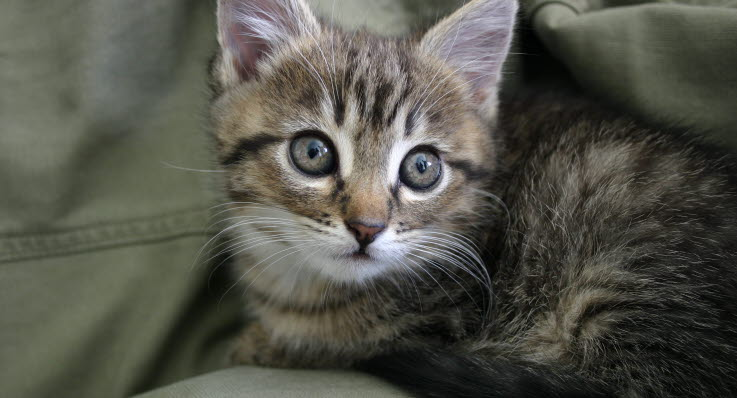

kitten 0.9995473
puppy 0.0002529661
bunny 0.00019965955
== Checking image pupu1.jpg ==


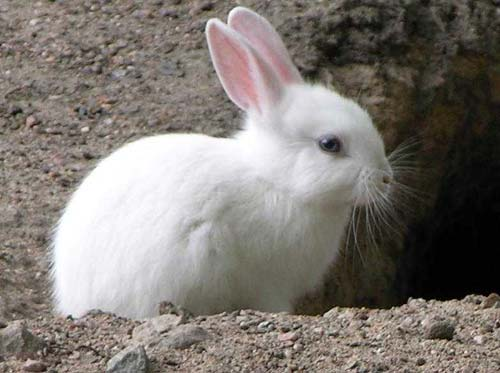

bunny 0.9999355
puppy 4.3237473e-05
kitten 2.1194033e-05
== Checking image pupu2.jpeg ==


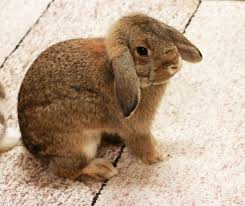

bunny 0.99314415
kitten 0.0055468166
puppy 0.0013090937
== Checking image pentu2.jpg ==


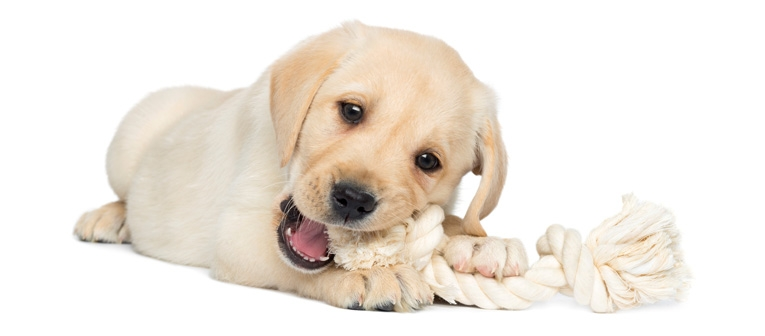

puppy 0.97280395
bunny 0.026508134
kitten 0.0006879502
== Checking image kissi1.jpeg ==


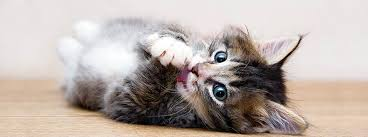

kitten 0.9956691
bunny 0.0042135785
puppy 0.00011726545
== Checking image pentu1.jpeg ==


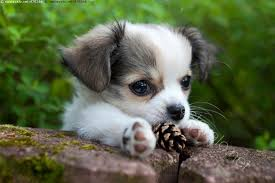

puppy 0.7626035
bunny 0.19046922
kitten 0.046927303


In [25]:
output_graph = imageDir + "output_graph.pb"
output_labels = imageDir + "output_labels.txt"

for r, d, folder in os.walk(testDir):
    for image in folder:
        print("== Checking image " + image + " ==")
        filename = testDir + str(image)
        display(Image(filename=filename))
        label_image(["--graph", output_graph, "--labels", output_labels, "--image", filename, "--input_layer", "Placeholder"])


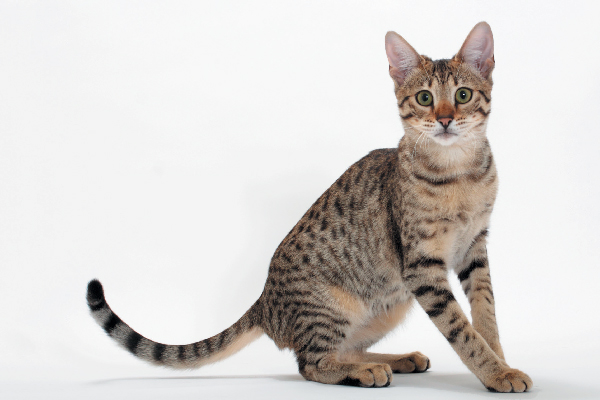

kitten 0.9959657
bunny 0.003406805
puppy 0.0006274558


[['kitten', ' 0.9960'], ['bunny', ' 0.0034'], ['puppy', ' 0.0006']]

In [24]:
def label_image_from_url(url):
    display(Image(requests.get(url).content))
    return label_image(["--graph", output_graph, "--labels", output_labels, "--input_layer", "Placeholder", "--url", url])

label_image_from_url("https://www.catster.com/wp-content/uploads/2018/07/Savannah-cat-long-body-shot.jpg")